<a href="https://colab.research.google.com/github/rafkol98/Unsupervised-Learning/blob/main/CS5014_Practical_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS5014 Practical 2 
##### Unsupervised learning and EM algorithm (Due date: 28 March 2022; MMS is the definite source for deadlines and weightings.)
##### 60% of the coursework grade

##### Student ID: 210017984



## Set-up

Load required packages (you can only use the imported packages).

In [ ]:
# if you use jupyter-lab, switch to %matplotlib inline instead
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.special import logsumexp
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from vmf import VonMisesFisher

Set a random generator with a fixed seed to have roughly the same result everytime

In [ ]:
# use fixed random number generator seed to have reproducible results
random_seed = 123
rng = np.random.default_rng(random_seed)

Read in dataset1:
* ``dataset1``: 500 observations and each with 4 features
* note that no cluster labels given for this dataset

In [ ]:
# read in dataset1
d1_df = pd.read_csv('./datasets/dataset1.csv', header=None)
dataset1 = np.array(d1_df)
# it should contain 500 observations and each with 4 dimensional input
n_dataset1, d_dataset1 = dataset1.shape

Read in dataset2, which contains 
* ``dataset2``: 500 observations; and each with 3000 features
* ``dataset2_labels``: the labels are listed in the last column; there are $K=4$ clusters

In [ ]:
# read in dataset2
d2_df = pd.read_csv('./datasets/dataset2.csv', header=None)
dataset2, dataset2_labels = d2_df.iloc[:, 0:-1], d2_df.iloc[:, -1]
dataset2 = np.array(dataset2)
dataset2_labels = np.array(dataset2_labels).astype(int)
n_dataset2, d_dataset2 = dataset2.shape

A quick demonstration of clustering performance evaluation
* use Sklearn.KMeans to fit a basic clustering model and 
* evaluate the clustering performance against the true label with normalised mutual information (NMI)

In [ ]:
# evaluate clustering performance by normalised mutual information.
# use Kmeans to learn the clusters: use the first four rows as centroids
km_dataset2 = KMeans(n_clusters=4, init=dataset2[0:4,:]).fit(dataset2)
# should expect approximately < 0.35 performance by using Kmeans
normalized_mutual_info_score(km_dataset2.labels_, dataset2_labels)

/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


0.30872980833029307

## Task 1. Spherical K-means

The first task is to implement a variant of K-means algorithm, which is called *Spherical K-means*. The algorithm follows a similar procedure as K-means but with slightly different assignment and update steps. In the following, we will explain the spherical K-means algorithm. 


**Initialisation step**: Start with randomly selecting $K$ data points as the centroid of $K$ clusters. 

**Assignment step**: *Spherical K-means* assigns a data point to the closest centroid based on *cosine distance* rather than Euclidean distance; specifically, for $i=1,\ldots, n$

$$z_i \leftarrow \arg\min_{k} \left (1- \frac{\mu_k^\top x_i }{\|\mu_k\| \cdot \|x_i\|}\right ),$$ where $\mu_k^\top x_i = \sum_{j=1}^d \mu_{kj} \cdot x_{ij}$ denotes the inner product and $\|x\|$ is $L_2$ norm of a vector $x$: $\|x\| = \sqrt{x^\top x}$.

**Update step**: *Spherical K-means* updates the centroids such that they are unit one vectors; for $k=1,\ldots, K$

$$\mu_k \leftarrow \frac{\sum_{i=1}^n I(z_i =k) \cdot x_i}{\|\sum_{i=1}^n I(z_i =k) \cdot x_i\|}.$$ Note that after the normalisation step, the centroids $\mu_k$ are norm-one vectors: i.e. $\|\mu_k\| = 1$ for $k=1,\ldots, K$.

**Repeat** the above two steps **until** the total cosine distance loss, defined as
$$\texttt{loss} = \sum_{i=1}^n \left (1- \frac{\mu_{z_i}^\top x_i }{\|\mu_{z_i}\| \cdot \|x_i\|}\right )$$ converges.



#### Task 1.1 Implementation of Spherical K-means

Your task is to complete the code for *assignment* and *update* steps at the given code template of `sphericalKmeans`.

The method `sphericalKmeans` has

**Inputs**:
* `data`: a $n\times d$ matrix to cluster, i.e. each row of $\texttt{data}$ is one observation $x_i$
* `K`: the number of the clusters
* `tol`: tolerence of error, which is used to check whether the loss has converged so the iteration can stop
* `maxIters`: the maximum number of iterations that is allowed

**Outputs**:
* `losses`: the whole trajectory of losses over the iterations
* `zs`: the clustering labels
* `us`: the learnt $K$ centroids

Feel free to write extra helper methods to make your implementation modularised. You may also rewrite the method altogether as long as your method respect the given mtehod's input/output signature. 

In [ ]:
def sphericalKmeans(data, K=3, tol= 1e-4, maxIters= 100):
    n, d = data.shape
    losses = np.zeros((maxIters))
    # Randomly assign K observations as centroids  
    init_us_ids = rng.integers(n, size = K)
    us = data[init_us_ids, :]
    # Create a zero array to store label for each data point.
    zs = np.zeros(n) 
    
    convergence_value = 9223372036854775807 #assign it to python's largest value.
    i = 0
    # loop until converge 
    while i < maxIters:
        # Assignment step - assign a data point the closest centroid (cosine dist).
        min_dis, zs = assignment_step(data, us, K)
        # update step
        us = update_step(data, zs, K)

        losses[i] = (sum(min_dis))
        convergence_value = (sum(min_dis)) # assign it as the convergence value.

        # Check convergence.
        if i > 0 and abs(losses[i] - losses[i-1]) < tol:
          i += 1
          break;
        else:
          i += 1 # increment if it didnt converge yet.

    return losses, zs, us      

In [ ]:
def assignment_step(data, us, K):
  '''Assign a data point to the closest centroid based on cosine distance.'''
  n, d = data.shape

  # Array used to store each point's minimum distance - from closest centroid.
  min_dis = []
  # Store the label of the K centroid closer.
  zs = []

  # Iterate through the points. For each point find the closest centroid.
  for i in range(n):
    # Calculate cosine distance of the current point from each centroid.
    distances = (list(1 - (np.inner(us[k][:], data[i][:]) / np.inner(np.linalg.norm(us[k][:]), np.linalg.norm(data[i][:]))) for k in range(K)))
    # Store the minimum distance to the min_dis array and its label to zs.
    min_dis.append(min(distances))
    zs.append(np.argmin(distances))
  return min_dis, zs

In [ ]:
def update_step(data, zs, K):
  '''Update μk by updating the centroids such that they are unit one vectors.'''
  n, d = data.shape
  # Create an array of dimensions K x d containing zeros. 
  # Will be used to store the updated us - learnt 𝐾 centroids.
  us = np.zeros((K, d))

  # Iterate through the clusters.
  for k in range(K):
    # Update the centroids such that they are unit one vectors - divide by the
    # vector's normalised L2 form - magnitude.
    μk =  sum([data[i][:] for i in range(n) if zs[i] == k]) / np.linalg.norm(sum([data[i][:] for i in range(n) if zs[i] == k]))
    us[k,:] = μk

  return us

#### Task 1.2 Evaluation

Run your implemented algorithm on `dataset1` with $K =3$. Note that like K-means, Spherical K-means also suffers from bad initialisations. To deal with that, we usually run the algorithm multiple times with different random initialisations. To make your life easier, you may want to write a wrapper method that does it automatically.

Please report the following information based on your results: 
* the learned 3 centroids
* and also plot the loss trajectory.

If you run multiple times, you only need to report the results for the best one.

In [ ]:
def evaluate_best_spherical(data, K=3, num_runs=10):
  '''Find the best performance across specified number of runs.'''
  convergence_value = 9223372036854775807 
  best_loss = []
  best_us = []
  best_zs = []

  # Run the algorithm num_runs times. Find the one performing the best.
  for i in range(num_runs):
    loss_temp, zs_temp, us_temp = sphericalKmeans(data, K=K)
    loss_temp = loss_temp[loss_temp != 0] # trim all the zeros.
    
    # Find the minimum loss value.
    if loss_temp[-1] < convergence_value:
      convergence_steps = len(loss_temp)
      # Assign the current loss and current us as the best.
      best_loss = loss_temp
      best_us = us_temp
      best_zs = zs_temp

  return best_us, best_loss, convergence_steps, best_zs

We select the best model by finding the one with the smallest loss value - across a specified number of runs.

In [ ]:
# Plot loss trajectory.
def plot_loss(loss, title, steps = 0):
  '''Plots the loss trajectory - on given steps.'''
  plt.figure(figsize = (12, 8))
  plt.rcParams.update({'font.size': 18})
  plt.plot(range(1,len(loss)+1), loss, label='Training Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  if steps != 0:
    steps_str = " - STEPS: " + str(steps)
    title = title + steps_str
  plt.title(title)
  plt.legend()
  plt.show()

The centroids learned by the algorithm Dataset 1 - BEST OF 20: 
 [[-0.01647354  0.71315821 -0.024021    0.70039773]
 [-0.50681396  0.4977044  -0.53574561  0.4565157 ]
 [-0.70180998  0.00302996 -0.71156038  0.03369567]]



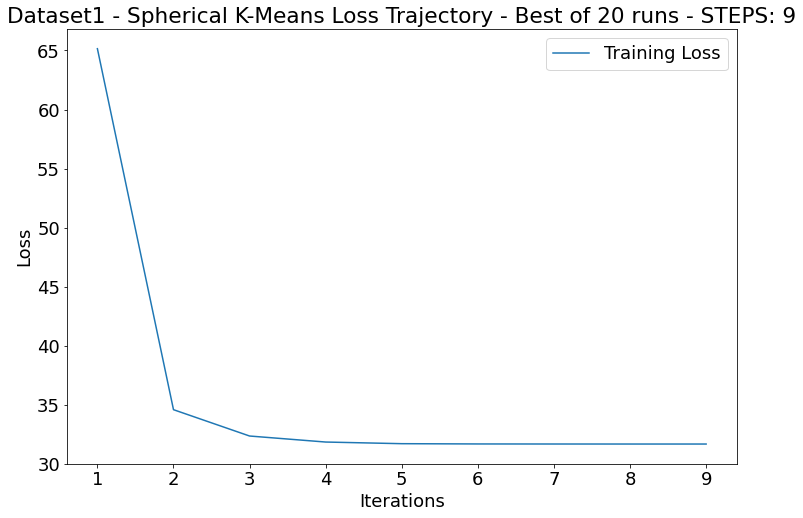

In [ ]:
# Show and plot the BEST run for dataset 1 (from 20 runs).
us_best_data1, loss_best_data1, steps_data1, zs_best_data1 = evaluate_best_spherical(dataset1, num_runs=20)
print(f"The centroids learned by the algorithm Dataset 1 - BEST OF 20: \n {us_best_data1}\n")
plot_loss(loss_best_data1, 'Dataset1 - Spherical K-Means Loss Trajectory - Best of 20 runs', steps_data1)

Now run your implemented algorithm on `dataset2` with $K =4$. And report the normalised mutual information between the returned cluster labels and true labels.

The centroids learned by the algorithm Dataset 2 - BEST OF 20: 
 [[ 0.00389413  0.00928112 -0.01160895 ...  0.01955345  0.00640026
   0.00481316]
 [-0.0172112  -0.00757138 -0.00495916 ... -0.01161611 -0.01580057
  -0.00375322]
 [-0.0113276   0.0117418   0.00487405 ... -0.01724064  0.01335131
   0.03500533]
 [-0.0072855  -0.01583824 -0.00633766 ...  0.00017014  0.01004589
   0.02801182]]



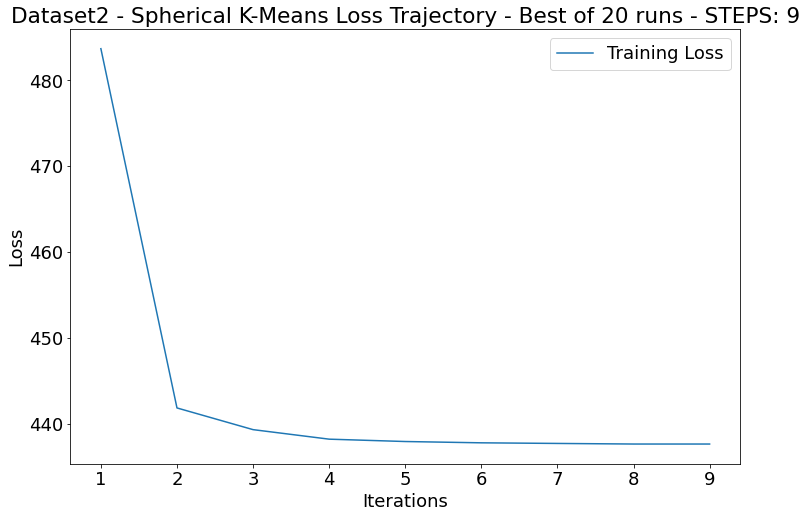

In [ ]:
# Show and plot the BEST run for dataset 2 (from 20 runs). Using 4 clusters.
us_best_data2, loss_best_data2, steps_data2, zs_best_data2 = evaluate_best_spherical(dataset2, K=4, num_runs = 20)
print(f"The centroids learned by the algorithm Dataset 2 - BEST OF 20: \n {us_best_data2}\n")
plot_loss(loss_best_data2, 'Dataset2 - Spherical K-Means Loss Trajectory - Best of 20 runs', steps_data2)

In [ ]:
# Find the best and average NMI performance across 20 runs.
best_nmi_kmeans = 0
all_nmi_kmeans = []
for i in range(50):
  _, zs_kmeans, _ = sphericalKmeans(dataset2, K=4)
  current_nmi = normalized_mutual_info_score(zs_kmeans, dataset2_labels)
  all_nmi_kmeans.append(current_nmi)
  if current_nmi > best_nmi_kmeans:
    best_nmi_kmeans = current_nmi

print(f"Best NMI performance KMEANS Dataset K=4: {best_nmi_kmeans}")
print(f"Average NMI performance KMEANS Dataset K=4: {np.mean(all_nmi_kmeans)}")

/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Best NMI performance KMEANS Dataset K=4: 0.3845439234074396
Average NMI performance KMEANS Dataset K=4: 0.1760573395828554


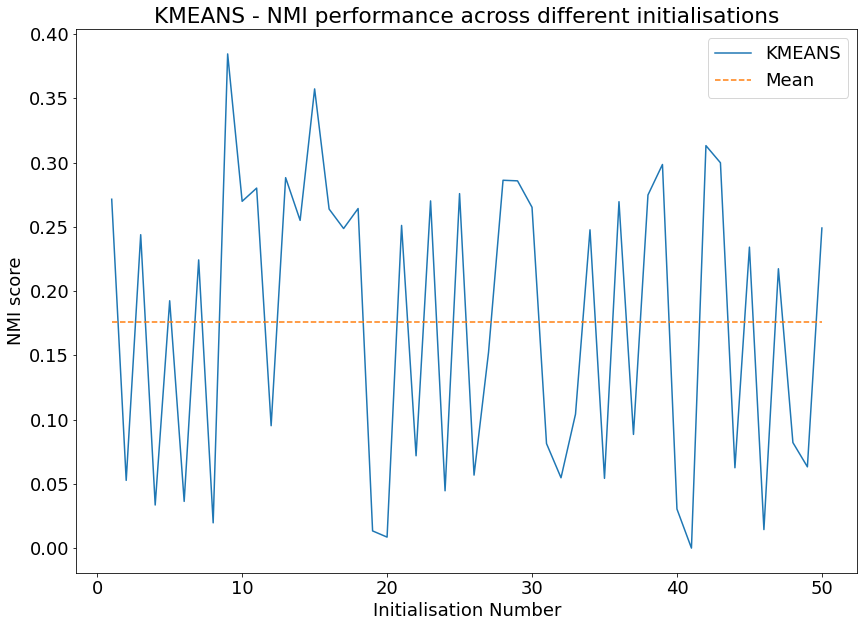

In [ ]:
# Plot KMEANS nmi performance across 50 different runs.
plt.figure(figsize=(14,10))
x = len(all_nmi_kmeans) # number of runs.
y = all_nmi_kmeans # NMI score.
y_mean = [np.mean(y) for i in y]
plt.title("KMEANS - NMI performance across different initialisations")
# Plot the nmi performance of kmeans across 50 runs
plt.plot(range(1,x+1), y, label = "KMEANS")
# Plot the average line
plt.plot(range(1,x+1),y_mean, label='Mean', linestyle='--')
plt.ylabel("NMI score")
plt.xlabel("Initialisation Number")
plt.legend()
plt.show()


A few observations:
*   As expected, KMEANS suffers from bad initialisations. If it does not make a good initial guess then it often performs very poorly. I tried to account for that by creating functions that enable the run of the algorithm multiple times and then selecting the run with the best performance (lower loss value) out of those.
*   The NMI score was calculated and visualised for multiple runs (not only the best) to visualise the difference in performance when bad and good initialisation happen. As we can see from the Figure there is great deviation in the NMI score, sometimes reaching only 2% NMI score accuracy and others ~38%. 
*   The **best performance** encountered on 50 runs was 38.45% and the average was 17.6%.





## Task 2: Fitting mixture of von Mises-Fisher

#### Background on von Mises-Fisher

In real world applications, datasets with very large dimensions, e.g. text and gene expression data, can be better modelled as directional vectors on a hypersphere rather than points in a Euclidean space. A probabilistic model that is suitable for this purpose is **von Mises-Fisher** distribution. In this task, we are going to implement a learning algorithm that can fit a finite mixture of von Mises-Fishers unsupervisedly. 

<img src="https://leo.host.cs.st-andrews.ac.uk/figs/CS5014/vmf.png" alt="Drawing" width="300"/>

Specifically, a vMF is a probability distribution over $d$-dimensional unit length vectors (i.e. $x \in R^d$ and $\|x\|=1$) and its probability density has the following functional form:
$$p(x|\mu, \kappa) = c_d(\kappa) \exp (\kappa \mu^\top x),$$
where 
* $\mu \in R^d$ and $\|\mu\|=1$, a unit length vector, is the mean direction of the distribution; 
* $\kappa > 0$ is the precision or concentration parameter that controls the spread of the distribution; larger concentration parameter $\kappa$ will make the distribution more concentratively clustered around the mean direction; 
* $c_d(\kappa)$ is the normalising constant such that the probability density integrates to one. 

Random samples from three different vMFs are shown in the figure above. The thick colored vectors mark their mean direction $\mu$s. And you can observe the effect of $\kappa$ directly. For example, the red vMF's spread is much smaller as it has a larger $\kappa$. Intuitively, you can think of vMF as an equivalence of Gaussian on hyperspheres rather than Euclidean space. The concentration parameter of vMF is just the inverse of the variance. 


It can be shown that the maximum likelihood estimators of vMF are

$$\mu_{ml} = \frac{\sum_{i=1}^n x_i}{\|\sum_{i=1}^n x_i\|},\;\; \kappa_{ml} \approx \frac{\bar r (d- \bar r^2)}{1- \bar r^2},$$

where $\bar r = \frac{\|\sum_{i=1}^n x_i\|}{n}$ is called *mean resultant length* in statistics community. And the **weighted maximum likelihood estimators** are

$$\tilde \mu_{ml} = \frac{\sum_{i=1}^n w_i x_i}{\|\sum_{i=1}^n w_i x_i\|},\;\; \tilde \kappa_{ml} \approx \frac{\tilde r (d- \tilde r^2)}{1- \tilde r^2},$$

where $\tilde r = \frac{\|\sum_{i=1}^n w_i x_i\|}{\sum_{i=1}^n w_i}$ is the weighted equivalence of the mean resultant length. And as expected, when you set $w_i=1$ for all $i$, we recover the normal MLE definition and also ML estimators. Note that the weighted ML estimators are defined as:
$$\tilde \mu_{ml}, \tilde \kappa_{ml} \leftarrow \arg\max_{\mu, \kappa} \sum_{i=1}^n w_i \log p(x_i|\mu, \kappa).$$ And recall what we have dicussed in Lecture 11 that weighted maximum likelihood estimation serves as the re-estimation step of an EM algorithm for a finite mixture model.


###### VonMisesFisher Class
A basic implementation of von Mises-Fisher in Python (`vmf.py` on studres) has provided for you. It has the following functionalities:
- instaniating a vMF instance with a given set of $\mu, \kappa$
- (log) density evaluation at one data input or a batch of data matrix (each row should be one observation), i.e. $\log p(x|\mu, \kappa)$
- randomly generate samples from a vMF

Check the following code snippets to familarise yourself with the class. The provided code should be enough for you to extend the model to finite mixture of vMFs, which is the core task of this practical.

1. Initialise 3 vMFs with $\mu_1 = [0, \frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}] , \kappa_1 = 5$; $\mu_2 = [-\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}] , \kappa_2 = 10$ and $\mu_3 = [0, -\frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}] , \kappa_3 = 80$.

In [ ]:
# to type μ: type \mu + tab; \kappa + tab for κ 
μs = np.array([[0,1/np.sqrt(2),-1/np.sqrt(2)], [-1/np.sqrt(2),0,1/np.sqrt(2)], [0,-1/np.sqrt(2),- 1/np.sqrt(2)]])
κs = np.array([5, 10, 80])
# initialise three vMFs with three different parameters
# use the random generator rng with a fixed seed to ensure reproduciability
vmf1= VonMisesFisher(μs[0,:], κs[0], rng)
vmf2= VonMisesFisher(μs[1,:], κs[1], rng)
vmf3= VonMisesFisher(μs[2,:], κs[2], rng)

2. Random sampling from vMFs and density evaluation

In [ ]:
# random sample 300, 100, 100 from the vMFs 
data_vmf1 = vmf1.sample(300)
data_vmf2 = vmf2.sample(100)
data_vmf3 = vmf3.sample(100)
# note that when you sample one observation, vmf.sample(1) still returns a 1 by d matrix
# you can transform it to an array e.g. by np.squeeze(vmf.sample(1))
# evaluate the density at those random samples
# logLiks_ is a 300 by 1 vector contains the log likelihood of vMF 1 evaluated at data_vmf1 
logLiks_ = vmf1.logpdf(data_vmf1)

3. You may want to visualise the samples (you can rotate the figure to see it better)
  * note the effect of $\kappa$: larger $\kappa$ leads to more concentrated samples

NameError: name 'data_vmf1' is not defined

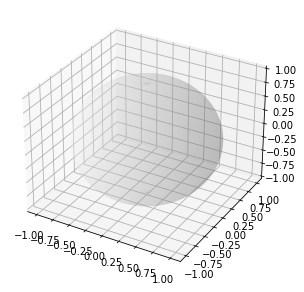

In [ ]:
plt.rcParams["figure.figsize"]=5,5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# sphere coordinates representation of the sphere (for better presentation)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 80)
x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
# plot a sphere
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='w', linewidth=0, alpha=0.2)
# plot the samples
ax.scatter(data_vmf1[:,0], data_vmf1[:,1], data_vmf1[:,2], marker ='x', s=5.0)
ax.scatter(data_vmf2[:,0], data_vmf2[:,1], data_vmf2[:,2], s=5.0)
ax.scatter(data_vmf3[:,0], data_vmf3[:,1], data_vmf3[:,2], s=5.0)

#### Task 2.1 randomly sample from a finite mixture of vMFs

Firstly, write a method that randomly generates samples from a finite mixture of vMFs. Recall the definition of a finite mixture model is 
$$p(x) = \sum_{k=1}^K \pi_k p(x| \mu_k, \kappa_k).$$

The method should have
**input** 
* `πs`: the prior mixture proportion $\pi_k$ for $k=1,\ldots, K$;
* `μs, κs`: $K$ set of vMF's parameters;
* `n`: number of samples to generate

and **output**
* `samples`: the gererated samples, should be a n by d matrix
* `zs`: the true cluster labels, where each $z_i \in 1, 2\ldots, K$ is the index of the cluster that has generated the i-th sample.



Once you have done so, use the implemented method to sample `n=500` samples from a ($K=3$) mixture of vMFs with following parameters:
* $\pi = [0.4, 0.3, 0.3]$
* $\mu_1 = [0, \frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}] , \kappa_1 = 10$; $\mu_2 = [-\frac{1}{\sqrt{2}}, 0, \frac{1}{\sqrt{2}}] , \kappa_2 = 25$$; $$\mu_3 = [0, -\frac{1}{\sqrt{2}}, -\frac{1}{\sqrt{2}}] , \kappa_3 = 50$

In [ ]:
# rng: a random number generator
def sample_mix_vmfs(πs, μs, κs, n, rng):
    '''Randomly generate samples from a finite mixture using vMFs distribution.'''
    K, dim = μs.shape
    
    samples = np.zeros((n,dim))
    zs = rng.choice(K, n, p=πs)
    
    # Iterate through all the number of samples to create.
    for i in range(n): 
      # Iterate through the clusters.
      for k in range(K):
        # if the true cluster label for the ith element is equal to the current
        # cluster being examined -> sample.
        if zs[i] == k:
          vmf = VonMisesFisher(μs[k,:], κs[k], rng)
          samples[i,:] = vmf.sample()
          
    return samples, zs

# to type μ: type \mu + tab; \kappa + tab for κ 
trueπs = np.array([0.4, 0.3, 0.3])
trueμs = np.array([[0,1/np.sqrt(2),-1/np.sqrt(2)], [-1/np.sqrt(2),0,1/np.sqrt(2)], [0,-1/np.sqrt(2),- 1/np.sqrt(2)]])
trueκs = np.array([10, 25, 50])
n_size = 500
# use the random generator rng with a fixed seed
simData, simData_labels = sample_mix_vmfs(trueπs, trueμs, trueκs, n_size, rng)

It is very useful to simulate data as this allows us to use the true labels and parameters (`trueπs`, `trueμs`, and `trueκs`) to test whether our functions (`estep`, `mstep`, `em_mix_vmfs`) work as expected, and ultimately whether our solutions are correct.

In [ ]:
def plot_data_spherical(data, zs, title=""):
  '''Plot the data along with its assigned label cluster in a 3-Dimensional sphere.'''
  fig = plt.figure(figsize=(10,10))
  
  ax = fig.add_subplot(111, projection='3d')
  ax.set_title(title)

  # sphere coordinates representation of the sphere (for better presentation)
  u = np.linspace(0, 2 * np.pi, 100)
  v = np.linspace(0, np.pi, 80)
  x = 1 * np.outer(np.cos(u), np.sin(v))
  y = 1 * np.outer(np.sin(u), np.sin(v))
  z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

  # plot a sphere
  ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='w', linewidth=0, alpha=0.2)
  # plot the samples
  for k in np.unique(zs):
    ax.scatter(data[zs==k,0], data[zs==k,1], data[zs==k,2], marker ='x', s=5.0)

This function is used to plot the data points of a passed in dataset in 3D. It can only be used for **3-dimensional** datasets.

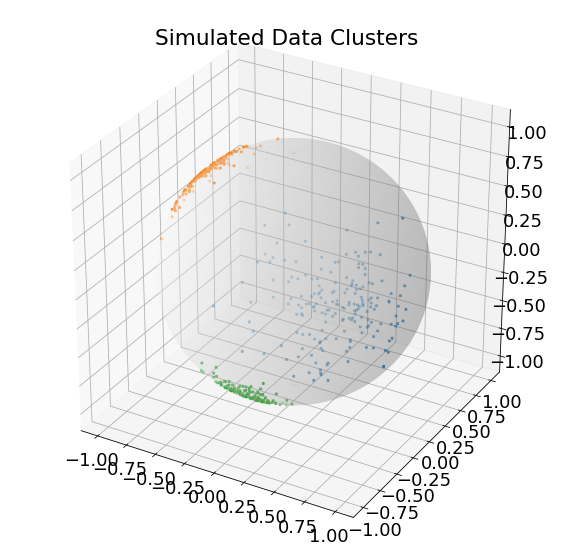

In [ ]:
# Let's plot the simulated data clusters.
plot_data_spherical(simData, simData_labels, "Simulated Data Clusters")

As evident the sampling step was performed correctly as the sampling data is the same as the one shown above.

#### Task 2.2 EM algorithm for mixture of vMFs

Implement an EM algorithm that can learn the parameters of finite mixture of vMFs. To achieve full mark on this task, you need to implement both
* EM algorithm with a soft E step (soft-EM)
* EM algorithm with a hard E step (hard-EM)

The method takes similar input as `sphericalKmeans` but it should output
* `logLiks`: the trajectory of the (log)-likelihood
* `πs, μs, κs`: the learnt parameters of the finite mixture model
* `zs`: the assigned clusters of the observations

Hint: it would be easier if you decompose the algorithm into E step (``estep`` with option of being soft `"s"` or hard `"h"` expectation step) and M step. Implement and test them independently and then combine them together to form a complete EM algorithm.

In [ ]:
def e_step(data, πs, μs, κs, estep="s"):
    '''Function that computes the expectation step. Combines both soft-step and hard-step. 
    Where soft (s) assigns a probability matrix in the ws (weights) variable, whereas
    hard (h) assigns the most likely label in the zs variable.'''
    n, d = data.shape
    K = len(πs)
    likelihoods = np.array([VonMisesFisher(μs[k,:], κs[k], rng).logpdf(data) for k in range(K)]).transpose()
    log_post = np.log(πs) + likelihoods # multiply prior with likelihood (adding because logs)
    log_sums = logsumexp(log_post, axis=1)
    log_likelihood = np.sum(log_sums)
 
    # Soft step - probability that it came from each cluster.
    if estep == "s":
      # Calculate ws - n (observations) by K (clusters) matrix.
      ws = np.exp(log_post - log_sums[:, None]) 
      return ws, log_likelihood
    # Hard step
    elif estep == "h":
      # Assign the most likely label for each data point.
      zs_ = np.argmax(log_post, axis=1)
      # Return the one-hot encoded matrix of the labels.
      zs_eye = np.eye(K)[zs_,:]
      return zs_, log_likelihood, zs_eye

**Testing of E-step**

In this subsection I ensure that both the soft step and hard step versions of E-step function properly.

**SOFT**

The weights matrix returned by **soft e-step**, is an n by K matrix where each inner entry shows the probability that the current data point belongs to a certain class/cluster.

To ensure that the weights returned by the e-step are as expected we can test that the **total sum** of the `ws` matrix is equal to `n`. Therefore, in this case 500.

$$\sum_{i=1}^n \sum_{k=1}^K w_{ik}$$

The inner sum (for each point) must therefore be equal to one. The sanitation check belows ensures that these results are correct.

In [ ]:
# Testing Soft-step
ws, log_likelihood = e_step(simData, trueπs, trueμs, trueκs)
print("TESTING E-STEP - SANITATION CHECK")
# sanitation check - total sum of weights should be equal to n (500).
# as each row must equal to 1. Np.isclose was used because when dealing with floats
# (that might contain very small decimal numbers) it is better to use the isclose 
# function rather than absolute equality.
total_sum_correct = np.isclose(np.sum(ws), 500, rtol=1e-05, atol=1e-1000, equal_nan=False)
print(f"The total sum of the weights matrix is equal to {np.sum(ws)}. Is this correct? {total_sum_correct}")

# Now for further validation lets check that indeed each row equals to one.
count_correct = 0 # counter of rows where their sum of probabilities equals one.
# Iterate through the rows (samples) of simulated data.
for i in range(len(simData)):
  # Count number of rows where the sum of probabilities is 1.
  if(np.isclose(np.sum(ws[i]), 1, rtol=1e-05, atol=1e-1000, equal_nan=False)):
    count_correct += 1

print(f"The sum of each of the {count_correct} rows is equal to 1? {count_correct == len(simData)}")

TESTING E-STEP - SANITATION CHECK
The total sum of the weights matrix is equal to 500.0. Is this correct? True
The sum of each of the 500 rows is equal to 1? True


**HARD**



Hard step still calculates the posterior probability but instead of returning a matrix with weights it returns an n-sized vector that contains the most likely cluster for each data point. The method returns the following:


1.   `zs_`: the most likely cluster for each data point.
2.   `log_likelihood`: the trajectory of the (log)-likelihood
3. `zs_eye`: One-hot encoded matrix of where (which cluster) each label belongs.

To test the h_step of the method, I pass in the simulated dataset's correct parameters (`trueπs`, `trueμs`, `trueκs`) and then plot the returned `zh_` clusters using the `plot_data_spherical`. If the plot is the same (same locations for data points) as the one visualised in the `sample_mix_vfms` step then we are sure its working correctly as it means that the algorithm returned all the correct cluster labels.



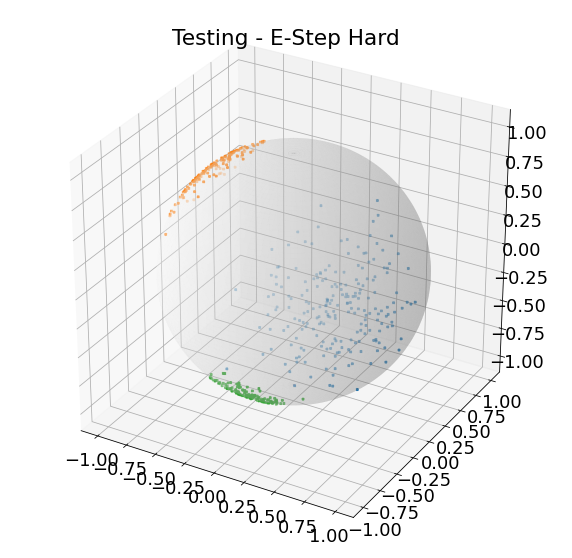

In [ ]:
# Run algorithm using the h-step.
zsh_, _, zsh_eye = e_step(simData, trueπs, trueμs, trueκs, "h")
# Plot returned zsh_ cluster labels.
plot_data_spherical(simData, zsh_, "Testing - E-Step Hard")

As evident the h_step works as expected - all the correct labels are returned.

Now for final check of the hard step, lets manually compare for equality between the first 10 labels from the `zs_` with their one-hot encoding value (`zs_eye`).

In [ ]:
# Print the first 10 values from zs_ and zs_eye to compare for equality.
print(zsh_[:10])
print(zsh_eye[:10])

[1 1 0 0 0 0 1 1 0 2]
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


The one-hot encoded matrix behaves correctly as all the values are correctly encoded. This proves that the `zs_eye` matrix behaves as expected.

**M Step**

The M Step uses Maximum Likelihood Estimation to re-estimate the parameters (θ) to be those with maximum likelihood, assuming that the distribution found in the E step is correct.


In [ ]:
def m_step(data, ws):
    '''The m_step function finds the weighted likelihood estimations of our parameters.'''
    n, d = data.shape
    K = ws.shape[1]

    # Calculate MLE for priors - π.
    ns = np.sum(ws, axis = 0)
    πs = ns / np.sum(ws)

    # Initialise empty matrixes for the concentration parameter.
    κs = np.zeros((K))
    μs = np.zeros((K, d))

    # Iterate through the number of Ks to calculate μ and κ for each one.
    for k in range(K):
      # Calculating MLE for μ.
      μ = data.transpose() @ ws[:,k]
      μs[k] = (μ / np.linalg.norm(μ)).transpose()

      # Weighted MLE for κs.
      weighted_r = np.linalg.norm(data.transpose() @ ws[:,k])/ sum(ws[:,k])
      κs[k] = (weighted_r * (d - np.square(weighted_r)))/(1- np.square(weighted_r))

      # cap κs values to avoid problems with vmfs normalising constant.
      κs = np.clip(κs, 1.0e-6, 1.0e+4)
      
    return πs, μs, κs

**Testing of M-step**

To check that the developed M-step works properly I do the following 2 tests:


1.   Calculate true weights using one-hot encoding for the simulated labels. Pass these weights to the `m_step` and store the parameters returned. Then call the `m_step` again, this time passing in the `ws` calculated in the estep. If the function behaves correctly the two should be almost identical. The difference has to be less than 1e-03.
2.   Compare the `trueκs`, `trueμs` and `trueπs` with the calculated ones - calculated with `trueWs`. If they are relatively close then it means that our algorithm behaves correctly.



In [ ]:
# TESTING m_step.

# Test 1. 
# Compare the values returned when the true responsibility matrix is passed in the
# m_step with the values returned when the ws calculated from e_step are passed in.
trueWs = np.eye(3)[simData_labels,:] # one-hot encode the weights using simulated labels.
πs_t, μs_t, κs_t = m_step(simData, trueWs)
πs_estimated, μs_estimated, κs_estimated = m_step(simData, ws)

# Test prior - π.
print(f"Are the πs close? \n{np.isclose(πs_t[:], πs_estimated[:], rtol=1e-03, atol=1e-03, equal_nan=False)}\n")
# Test the mean direction of the distribution - μ.
print(f"Are the πs close? \n{np.isclose(μs_t[:], μs_estimated[:], rtol=1e-03, atol=1e-03, equal_nan=False)}\n")
# Test the concentration parameter - κ.
print(f"Are the κs close? \n{np.isclose(κs_t[:], κs_estimated[:], rtol=1e-03, atol=1e-03, equal_nan=False)}\n")

Are the πs close? 
[ True  True  True]

Are the πs close? 
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]

Are the κs close? 
[ True  True  True]



As evident all the values are very close, within 1e-03 tolerance. They are not expected to be exactly equal of course as in the first run we are using the one-hot encoded true weights and in the other one the estimation probabilities that were returned by the e_step. The 1e-03 value chosen I believe is sensible in comparing almost equality.

In [ ]:
# TEST 2
# Manually compare prior - π.
print("Prior - π")
print(f"π value after m_step: {πs_t}")
print(f"true π value: {trueπs}")

# Manually compare the mean direction of the distribution - μ.
print("\nDirection of the distribution - μ")
print(f"μ value after m_step: {μs_t}")
print(f"true μ value: {trueμs}")

# Manually compare the concentration parameter - κ.
print("\nConcentration parameter - κ")
print(f"κ value after m_step: {κs_t}")
print(f"true κ value: {trueκs}")

Prior - π
π value after m_step: [0.428 0.284 0.288]
true π value: [0.4 0.3 0.3]

Direction of the distribution - μ
μ value after m_step: [[ 0.01162749  0.70837296 -0.70574255]
 [-0.70043107  0.01139383  0.7136291 ]
 [ 0.01201369 -0.70668379 -0.70742752]]
true μ value: [[ 0.          0.70710678 -0.70710678]
 [-0.70710678  0.          0.70710678]
 [ 0.         -0.70710678 -0.70710678]]

Concentration parameter - κ
κ value after m_step: [10.4969735  23.19710466 53.64888441]
true κ value: [10 25 50]


As evident all estimated MLE values are relatively close to the `true` values for each parameter. This further proves the correctness of the m_step.

**EM MIX**

EM algorithm combining soft and hard step *estep* with *mstep*. The *directed_assignment* variable determines whether to give the algorithm some reasonable initialisations at the beginning. 

If `directed_assignment` is false, then the algorithm blindly assigns labels just like KMEANS. Otherwise (`directed_assignment = True`), it initialises the values it should expect **within an informed range**.

If no initialisations are given at the beginning (`directed_assignment=False`) then the `mstep` is performed first to assign the parameters (`πs, μs, κs`). The history for the parameters and log likelihood is stored to be able to plot iteration visualisations.

Each iteration should improve the true likelihood, or leave it unchanged - if a local maximum has already been found.

In [ ]:
def em_mix_vmfs(data, K=3, estep="s", tol= 1e-4, maxIters= 100, directed_assignment=False):
  '''Put the Estep and Mstep together.'''
  n, d = data.shape
  z_init = []
  # If the directed assignment is true we give the algorithm some reasonable initialisations.
  if directed_assignment:
    πs = np.random.randint(1,100,K)
    πs = πs/sum(πs)
    μs = data[rng.integers(n, size = K)]
    κs = np.random.randint(1, 50, K)
  # Otherwise it starts completely blind - similar to KMeans.
  else:
    z_init = rng.integers(K, size=n)
    ws = np.eye(K)[z_init]

  # Create matrices to store the history of the values.
  μs_history = np.zeros((maxIters, K, d))
  πs_history = np.zeros((maxIters, K))
  κs_history = np.zeros((maxIters, K))
  log_likelihoods = np.zeros(maxIters)

  converged = False
  i = 0
  while(not converged and i < maxIters):
    # if the assignment is not directed (initialised variables) perform M-step first.
    if not directed_assignment:
      πs, μs, κs = m_step(data, ws)

    # E-step - soft.
    if estep == "s":
      ws, log_likelihood = e_step(data, πs, μs, κs)

    # E-step - hard.
    elif estep == "h":
      zs, log_likelihood, ws = e_step(data, πs, μs, κs, estep='h')

    # If the assignment is directed, perform m_step after e_step.
    if directed_assignment:
      πs, μs, κs = m_step(data, ws)

    # Store values in history matrices.
    μs_history[i,:,:] = μs
    πs_history[i,:] = πs
    κs_history[i,:] = κs

    # Check if the algorithm converged.
    log_likelihoods[i] = log_likelihood
    if i > 0 and abs(log_likelihoods[i] - log_likelihoods[i-1]) <= tol:
      converged = True
      break;

    i += 1 # increment if it didnt converge yet.
  
  if estep == "s":
    zs = np.argmax(ws, axis=1)

  return πs, μs, κs, μs_history, πs_history, κs_history, np.nan_to_num(log_likelihoods), zs, z_init

#### Task 2.3 Test your algorithm on simulated dataset of Task 2.1

The objective of this task is to test whether your algorithm works by using a simulated dataset with known ground truth. Again, you may need to repeat the algorithm a few times with different random initialisations to avoid bad initialisations. Run your EM algorithm on the dataset simulated in task 2.1. You need to show:
* whether your algorithm can recover the true parameters when correct $K=3$ is given ? 
* plot the (log)Likelihood trajectory

Report your results below.

In [ ]:
def pick_best_run(data, K, estep="s", tol= 1e-4, maxIters= 100, num_runs = 10, directed_assignment=False):
  '''Runs the algorithm specified amount of times and returns the best run.
  The best run is determined by finding the run with the maximum log likelihood'''
  n, d = data.shape
  # Initialise variables where we will store all the values for each run.
  all_πs = np.zeros((num_runs, K))
  all_μs = np.zeros((num_runs, K, d))
  all_κs = np.zeros((num_runs, K))
  all_μs_history = np.zeros((num_runs, maxIters, K, d))
  all_πs_history = np.zeros((num_runs, maxIters, K))
  all_κs_history = np.zeros((num_runs, maxIters, K))
  all_log_likelihood = []
  all_zs = np.zeros((num_runs, n))
  all_z_init = np.zeros((num_runs, n)) # initial assignments.

  all_log_likelihood_max_value = np.zeros((num_runs))
  # Run the algorithm specified number of times.
  for i in range(num_runs):
    πs, μs, κs, μs_history, πs_history, κs_history, likelihood, z, z_init = em_mix_vmfs(data, K=K, maxIters=maxIters, estep=estep, tol=tol, directed_assignment=directed_assignment)
    all_μs[i,:,:] = μs
    all_πs[i,:] = πs
    all_κs[i,:] = κs
    all_μs_history[i,:,:, :] = μs
    all_πs_history[i,:, :] = πs
    all_κs_history[i,:, :] = κs
    likelihood_trimmed = likelihood[likelihood != 0] # trim all the zeros at the end.
    all_log_likelihood.append(likelihood_trimmed)
    all_log_likelihood_max_value[i] = likelihood_trimmed[-1] # store last value.
    all_zs[i] = z
    all_z_init[i] = z_init 

  # Find index of best run.
  index = np.argmax(all_log_likelihood_max_value, axis=0)
  # Return all parameters of best run.
  return all_πs[index,:], all_μs[index,:,:], all_κs[index,:], all_μs_history[index,:,:,:], all_πs_history[index,:,:], all_κs_history[index,:,:], all_log_likelihood[index], all_zs[index,:], all_z_init[index,:]

In [ ]:
def print_results(πs, μs, κs, loss, max_iters, experiment_title):
  '''Print results of the parameters estimated using EM algorithm in a formatted way.'''
  
  print(f"Results for: {experiment_title}")
  print(f"Estimated πs are: \n{πs}\n")
  print(f"Estimated μs are: \n{μs}\n")
  print(f"Estimated κs are: \n{κs}\n")

  print("\nLoss Trajectory Plot\n")
  plot_likelihood_trajectory(loss, f"Log-likelihood Trajectory Plot {experiment_title}")

In [ ]:
def plot_likelihood_trajectory(log_likelihood, title, steps = 0):
  '''Plot the log likelihood trajectory passed in.'''

  plt.figure(figsize = (12, 8))
  plt.rcParams.update({'font.size': 18})
  plt.plot(range(1,len(log_likelihood)+1), log_likelihood, label='Log-likelihood Trajectory')
  plt.xlabel('Iterations')
  plt.ylabel('Log-likelihood')
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
def plot_iteration_history(data, μs_history, πs_history, κs_history, log_likelihood, z_init):
  '''Plot the iteration history of a run.'''
  index = len(log_likelihood)
  step = int(index/10) # do steps equivalent to index divided by 10.

  # Plot initial random assignment.
  plot_data_spherical(data, z_init, "Initial Random Assignment")

  if index >= 1:
    # if step is zero (in case it took less than 10 steps to converge) 
    # then asign the step to 1.
    if (step == 0):
      step = 1

    # Get labels for each iteration - plot them in the spherical plot.
    for iter_ in  np.arange(0, index, step):
        zs, _, _ = e_step(data, πs_history[iter_,:], μs_history[iter_,:], κs_history[iter_,:], estep="h")
        plot_data_spherical(data, zs, "iteration: " + str(iter_) +" logLik: "+ str(round(log_likelihood[iter_],3)))


The following runs use the **undirected** version of the EM algorithm developed (without initialisations) unless stated otherwise. This is to enable for more representative comparison with KMeans.

**Simulated Data - Soft Step**

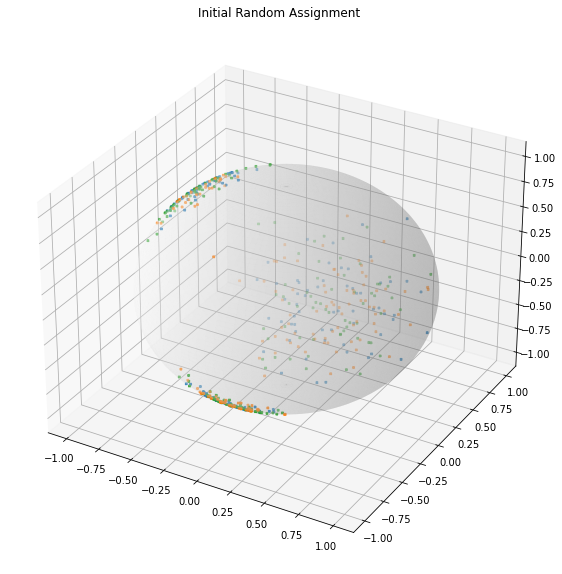

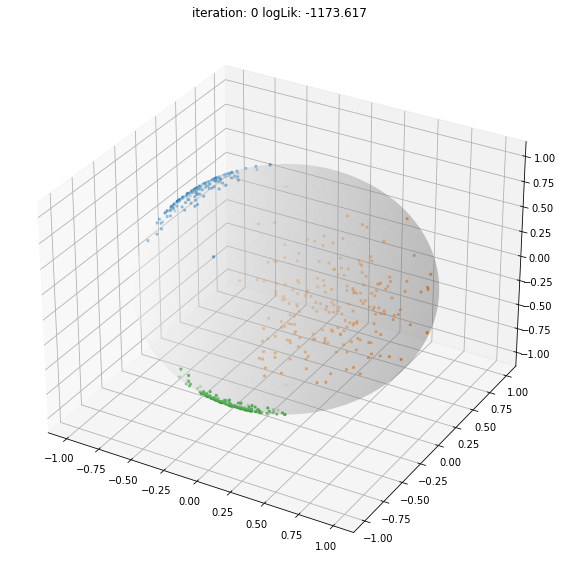

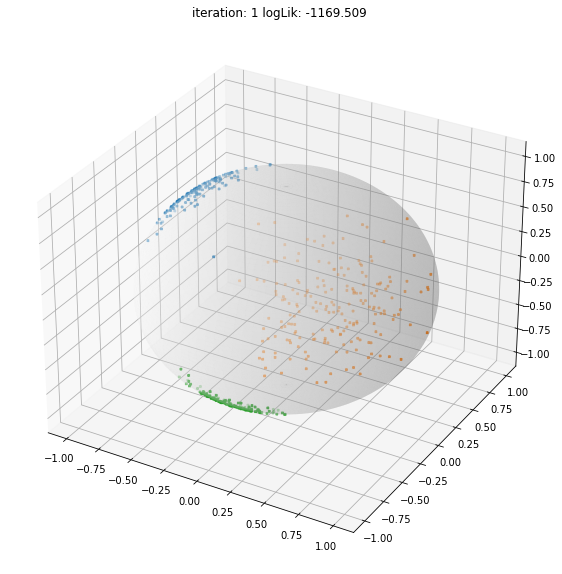

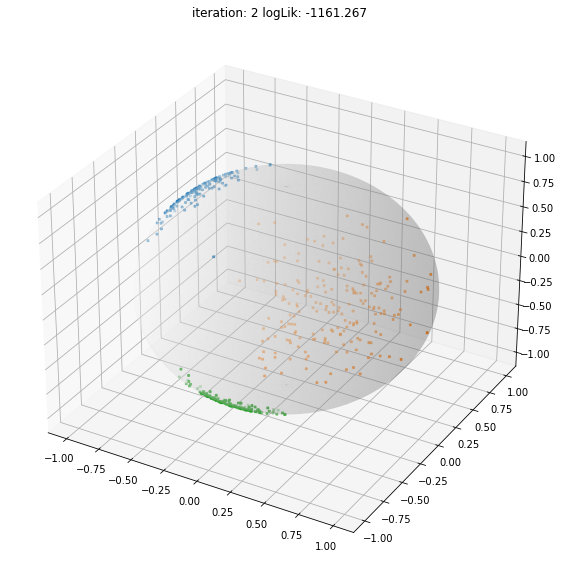

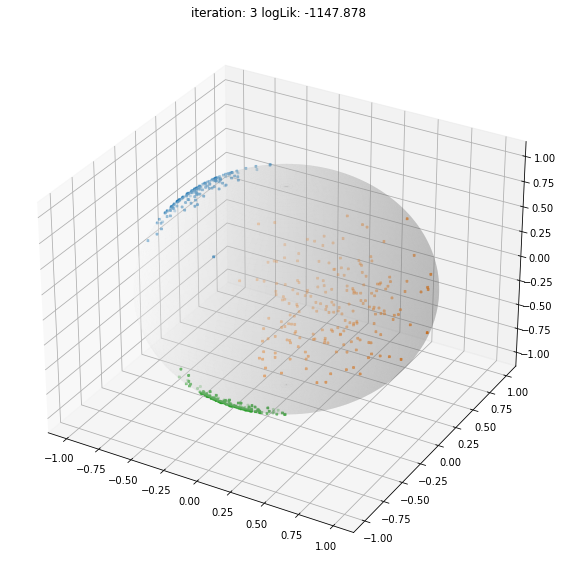

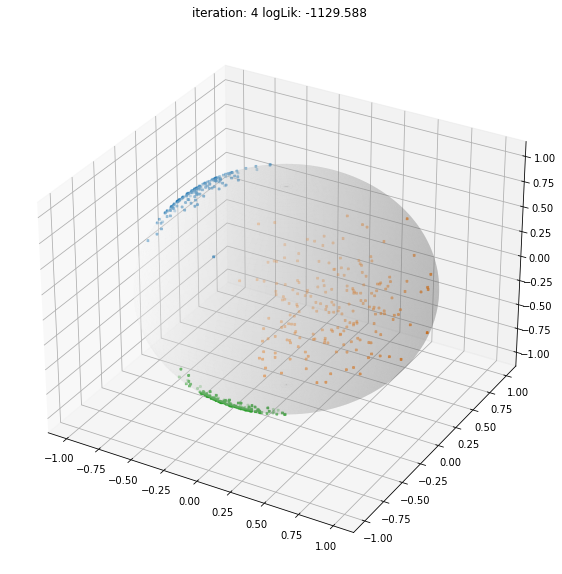

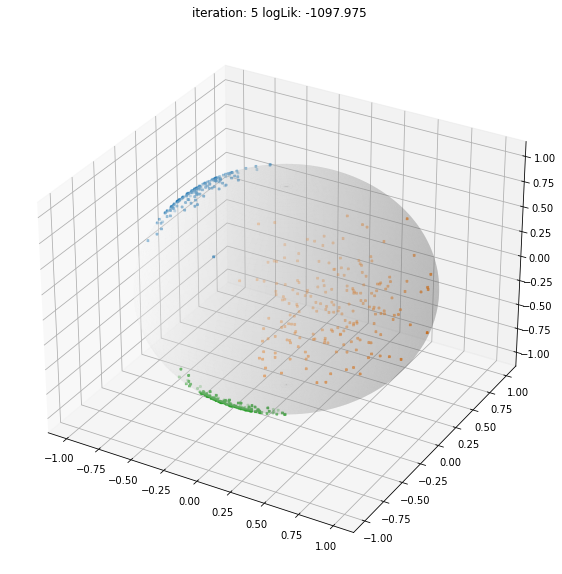

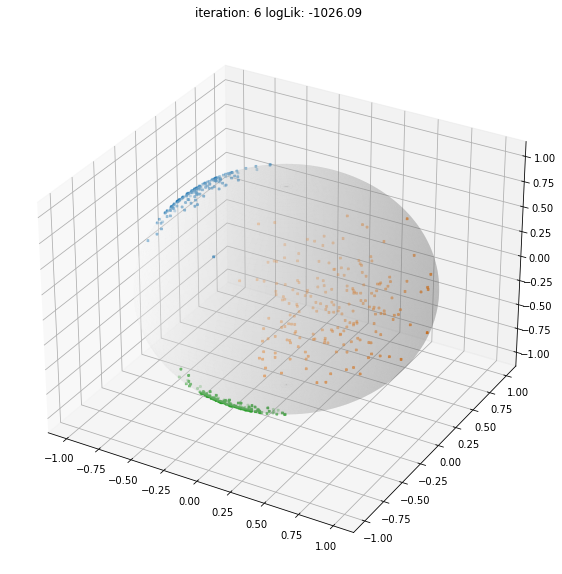

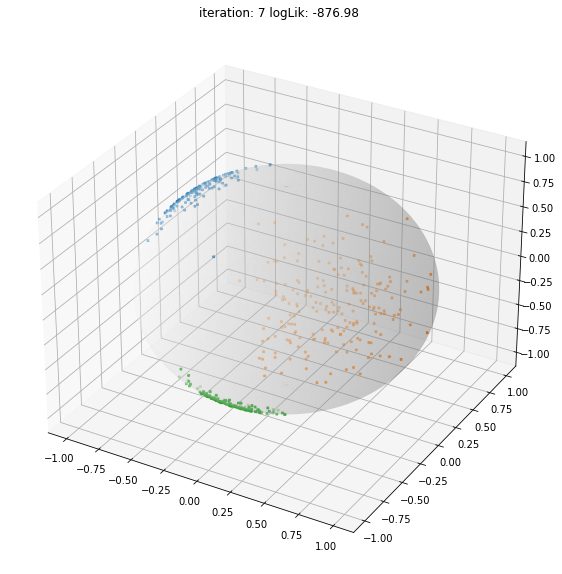

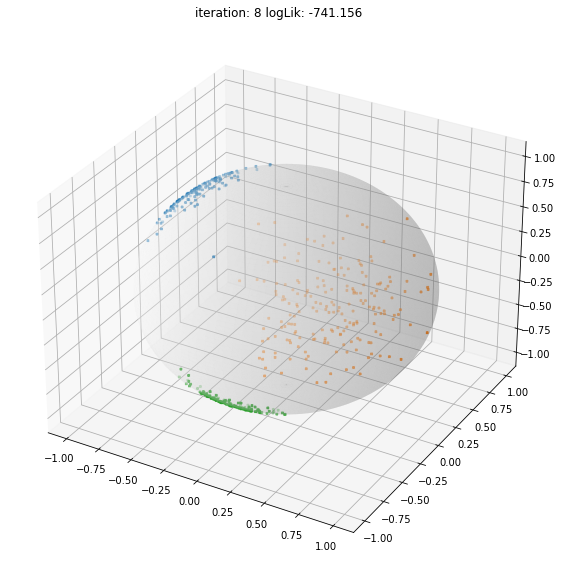

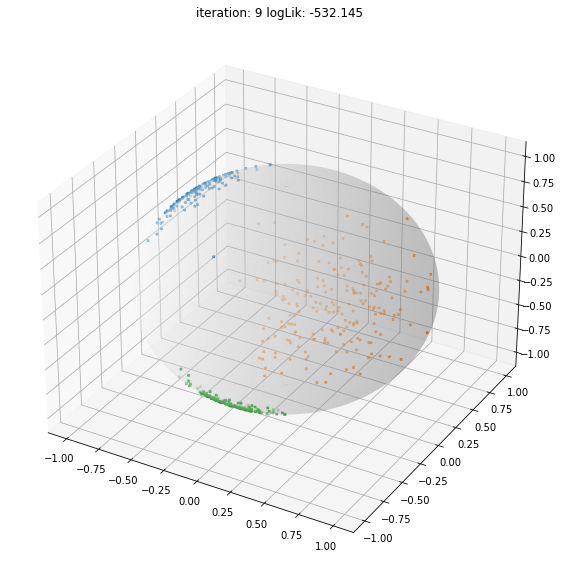

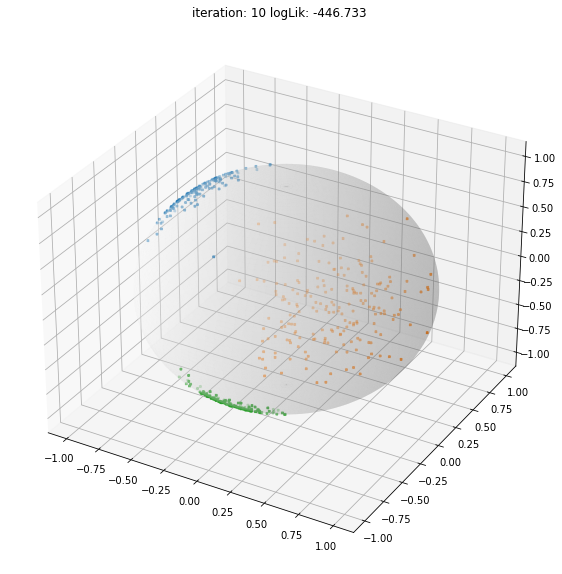

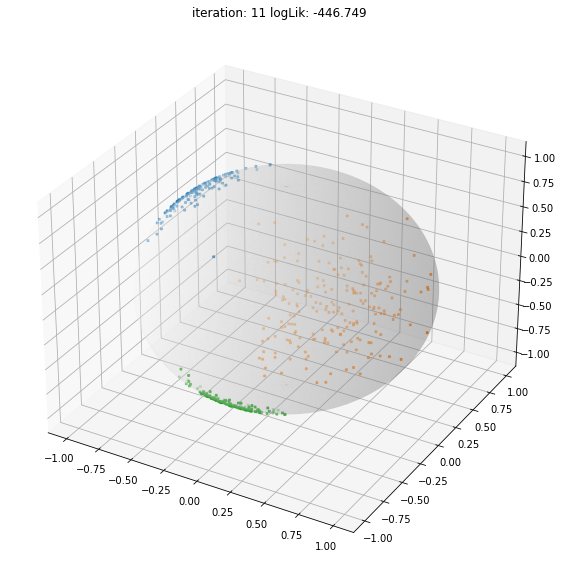

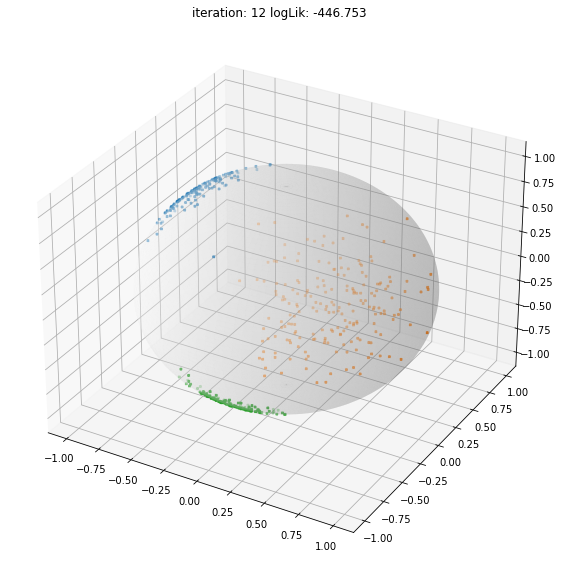

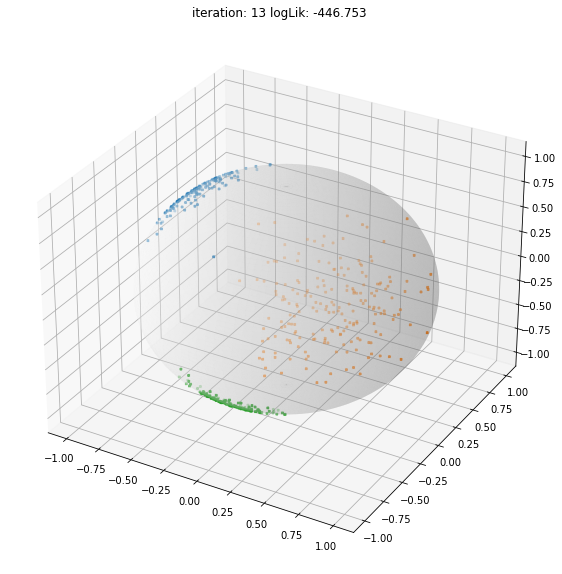

In [ ]:
πs_sim_s, μs_sim_s, κs_sim_s, μs_history_sim_s, πs_history_sim_s, κs_history_sim_s, log_likelihood_sim_s, _, z_init_sim_s = pick_best_run(simData, K=3, estep="s", num_runs = 50)
plot_iteration_history(simData, μs_history_sim_s, πs_history_sim_s, κs_history_sim_s, log_likelihood_sim_s, z_init_sim_s)

Results for: EM Soft - Simulated Dataset
Estimated πs are: 
[0.2859934  0.40009544 0.31391116]

Estimated μs are: 
[[-0.69905586  0.0191662   0.71481016]
 [-0.00331907  0.71683207 -0.69723795]
 [-0.01855789 -0.7101473  -0.70380851]]

Estimated κs are: 
[27.0312859  10.11974777 43.8018443 ]


Loss Trajectory Plot



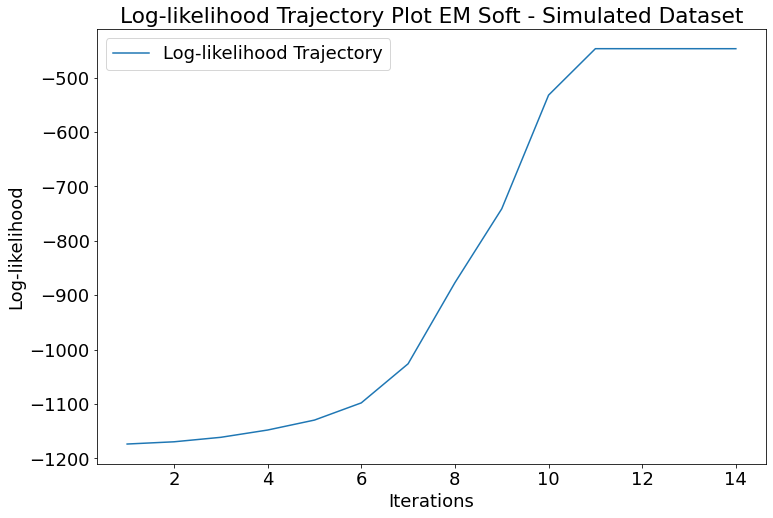

In [ ]:
print_results(πs_sim_s, μs_sim_s, κs_sim_s, log_likelihood_sim_s, max_iters=100, experiment_title = "EM Soft - Simulated Dataset" )

**Simulated Data - Hard Step**

/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


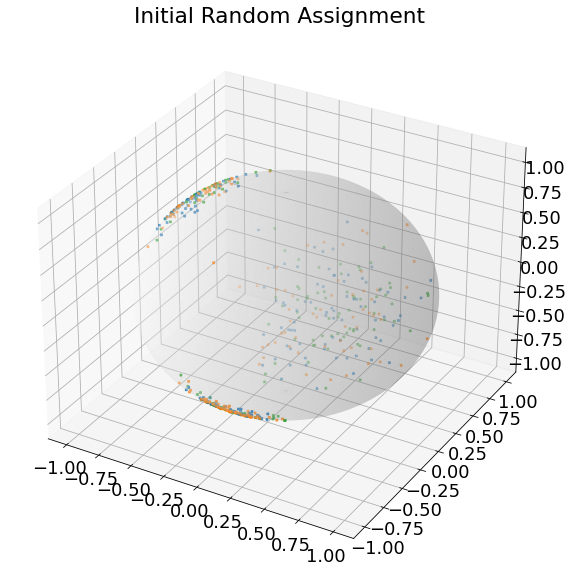

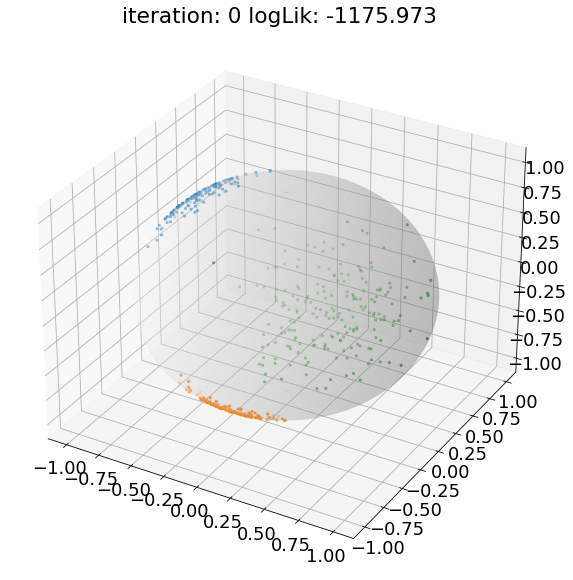

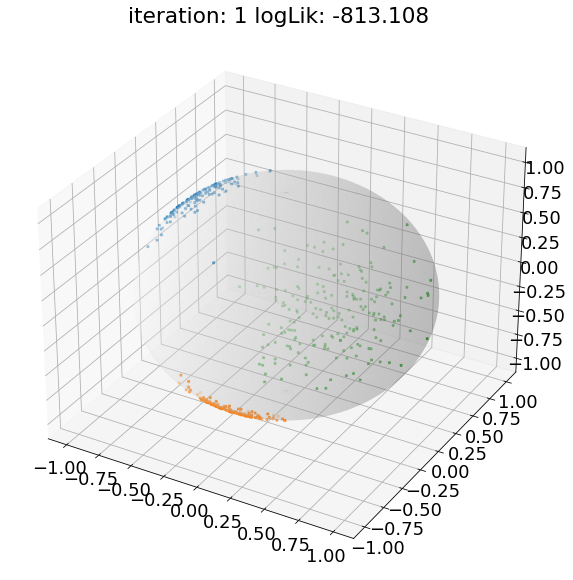

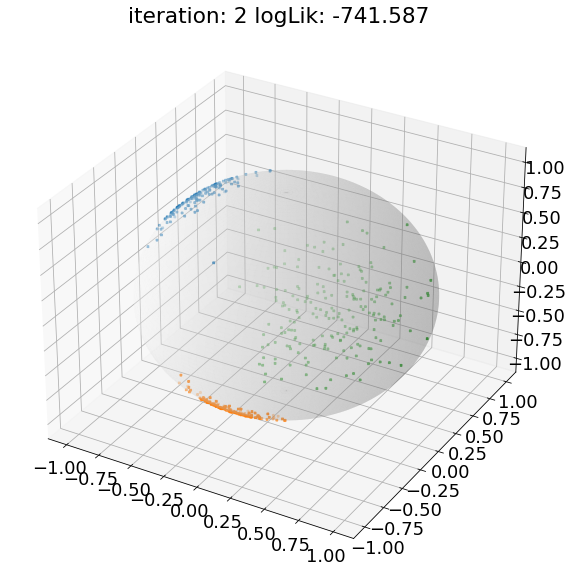

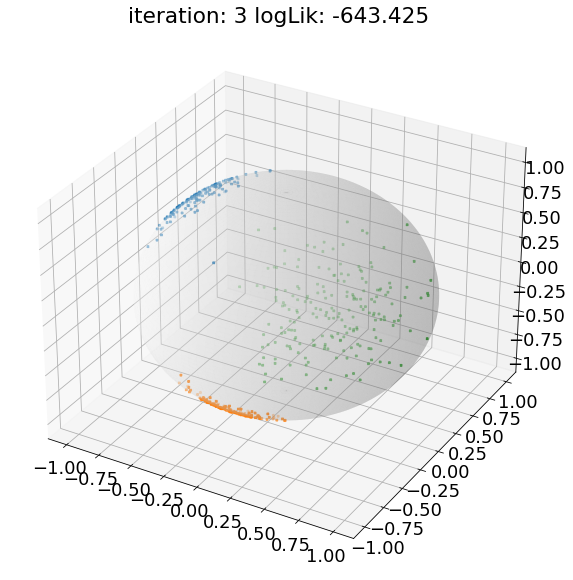

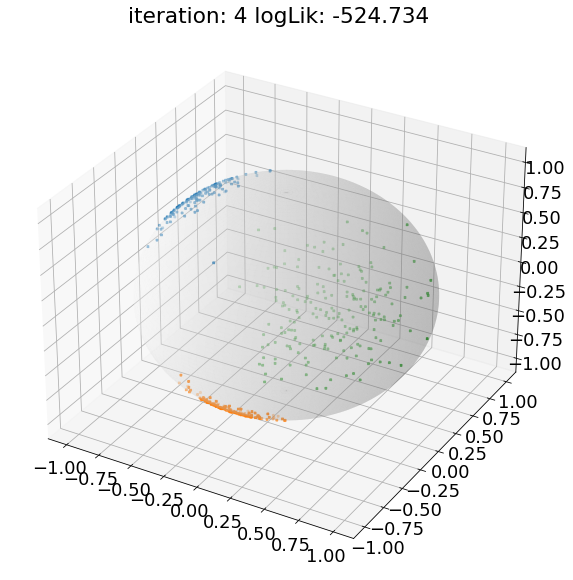

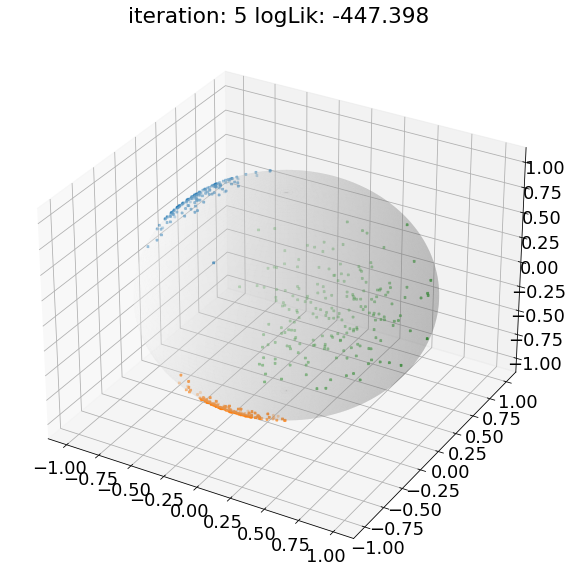

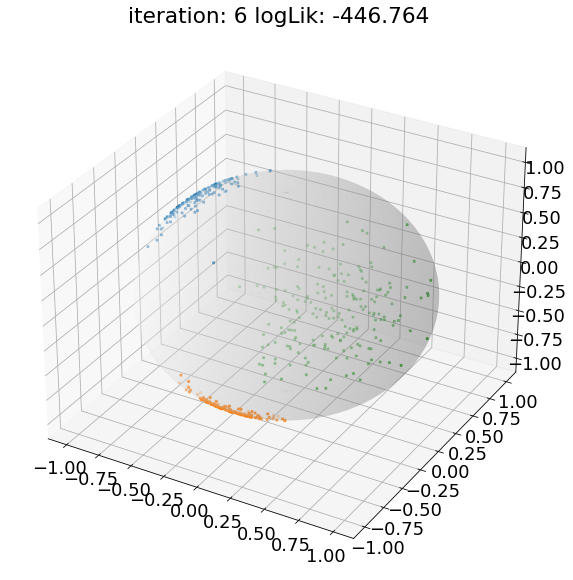

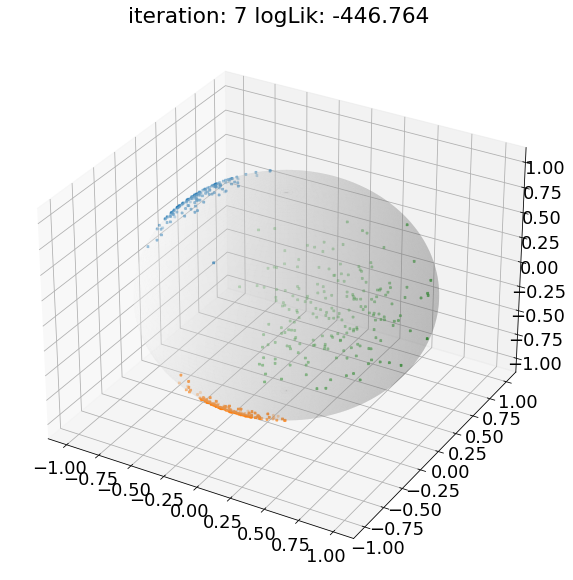

In [ ]:
πs_sim_h, μs_sim_h, κs_sim_h, μs_history_sim_h, πs_history_sim_h, κs_history_sim_h, log_likelihood_sim_h, _, z_init_sim_h = pick_best_run(simData, K=3, estep="h", num_runs = 50)
plot_iteration_history(simData, μs_history_sim_h, πs_history_sim_h, κs_history_sim_h, log_likelihood_sim_h, z_init_sim_h)

Results for: EM Hard - Simulated Dataset
Estimated πs are: 
[0.286 0.314 0.4  ]

Estimated μs are: 
[[-0.69905724  0.01917609  0.71480854]
 [-0.01852573 -0.7100906  -0.70386656]
 [-0.00333036  0.71698546 -0.69708017]]

Estimated κs are: 
[27.02962135 43.77891926 10.13489414]


Loss Trajectory Plot



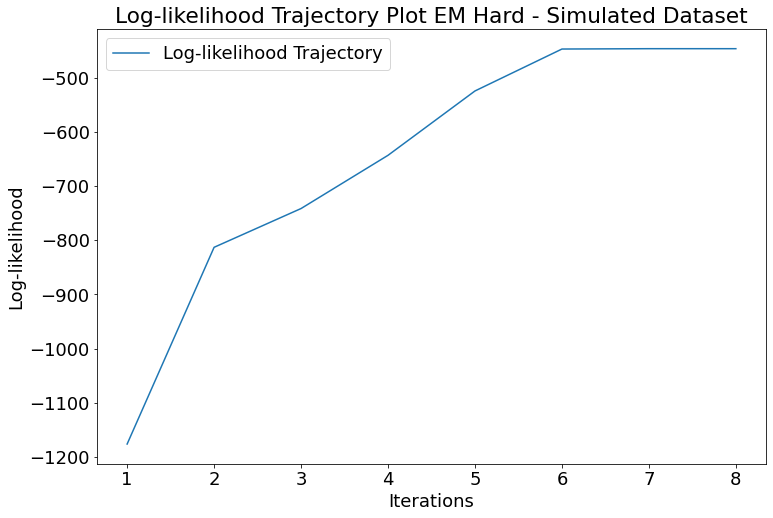

In [ ]:
print_results(πs_sim_h, μs_sim_h, κs_sim_h, log_likelihood_sim_h, max_iters=100, experiment_title = "EM Hard - Simulated Dataset")

As both algorithms find almost the exact parameter values when given K=3. This proves that the algorithms work as they should as they reach these results based on completely random initialisations at the beginning (not directed - `directed_assignment = False`). It is also worth noting that the h-step reaches a very similar solution with s-step using fewer iterations.

#### Task 2.4 Evaluation on given datasets

Now run your EM algorithms (both soft and hard if you have implemented both) on `dataset1` with $K=3$. As no labels are given, you only need to report the estimated $\mu_k$,$\kappa_k$ for $k=1,\ldots, K$ and $\pi$.

**Dataset1 - Soft Step**

Results for: EM Soft - Dataset1
Estimated πs are: 
[0.27965422 0.44064034 0.27970544]

Estimated μs are: 
[[-0.70281071 -0.02501384 -0.71069551  0.01852863]
 [-0.51588511  0.4856086  -0.54466428  0.44876236]
 [ 0.00149241  0.71687239 -0.00410891  0.69719069]]

Estimated κs are: 
[21.93573051 15.97230978 50.55007834]


Loss Trajectory Plot



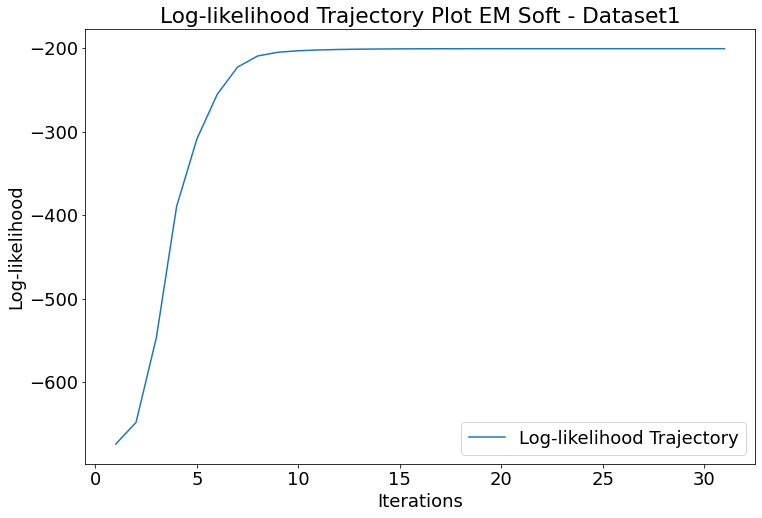

In [ ]:
# Dataset 1, K=3 soft step.
πs_d1, μs_d1, κs_d1, μs_history_d1, πs_history_d1, κs_history_d1, log_likelihood_d1, _, _ = pick_best_run(dataset1, 3, num_runs= 50)
print_results(πs_d1, μs_d1, κs_d1, log_likelihood_d1, max_iters=50, experiment_title = "EM Soft - Dataset1" )

/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/cs/home/rk81/CS5014/python/lib64/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


Results for: EM Hard - Dataset1
Estimated πs are: 
[0.42  0.282 0.298]

Estimated μs are: 
[[-0.50271254  0.49565091 -0.53551616  0.46350051]
 [ 0.00122682  0.71651742 -0.00243971  0.69756385]
 [-0.70429439 -0.01644091 -0.70955284  0.01529275]]

Estimated κs are: 
[17.5184828  51.20433686 22.55887683]


Loss Trajectory Plot



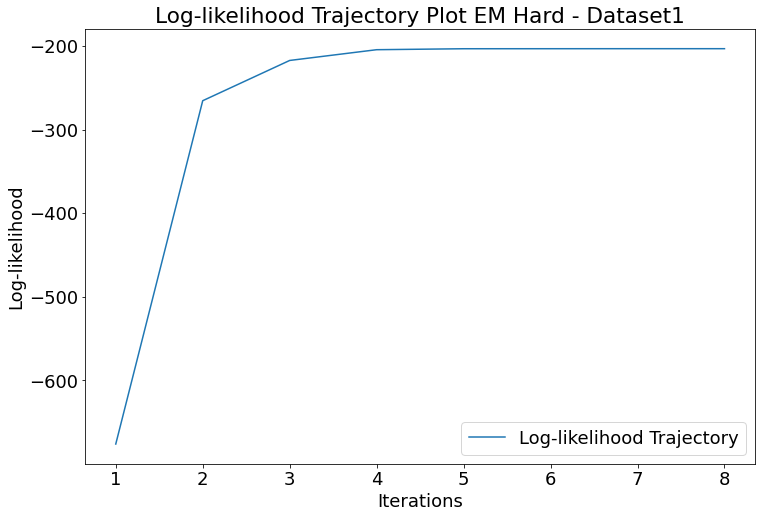

In [ ]:
# Dataset 1, K=3 hard step.
πs_d1_h, μs_d1_h, κs_d1_h, μs_history_d1_h, πs_history_d1_h, κs_history_d1_h, log_likelihood_d1_h, _, _ = pick_best_run(dataset1, 3, num_runs= 50, estep="h")
print_results(πs_d1_h, μs_d1_h, κs_d1_h, log_likelihood_d1_h, max_iters=50, experiment_title = "EM Hard - Dataset1" )

Run your EM algorithm on `dataset2` with $K=4$ and report the NMI performance. Compare the clustering performance with Sperical K-means and present the comparison result in a suitable format (e.g. table or figure).

Results for: EM Soft - Dataset2
Estimated πs are: 
[0.18199915 0.30799972 0.26000005 0.25000109]

Estimated μs are: 
[[-0.01755368  0.01956709  0.00706087 ... -0.0194662  -0.0186232
  -0.0162709 ]
 [-0.02404128  0.01616332 -0.02510629 ... -0.01296368  0.02498387
   0.02656683]
 [ 0.00027303 -0.0203945  -0.00210416 ... -0.00062502  0.00660621
   0.02175131]
 [ 0.00761039 -0.00246127 -0.0023163  ...  0.0245144   0.00202116
   0.01620741]]

Estimated κs are: 
[361.98882818 273.82373723 534.64710266 526.52909136]


Loss Trajectory Plot



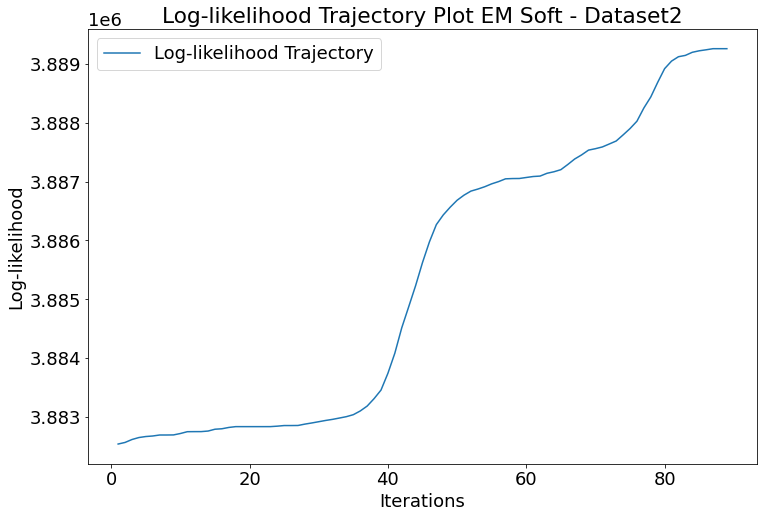

In [ ]:
# Dataset 2, K=4 soft step.
πs_d2, μs_d2, κs_d2, μs_history_d2, πs_history_d2, κs_history_d2, log_likelihood_d2, _, _ = pick_best_run(dataset2, 4, num_runs= 100, maxIters = 100)
print_results(πs_d2, μs_d2, κs_d2, log_likelihood_d2, max_iters=50, experiment_title = "EM Soft - Dataset2" )

Results for: EM Hard - Dataset2
Estimated πs are: 
[0.17999953 0.26000048 0.30599993 0.25400006]

Estimated μs are: 
[[-9.66763768e-03  3.55734216e-03 -1.78784591e-02 ... -3.69593537e-03
   4.07232517e-03 -1.56953180e-02]
 [ 2.74756110e-04 -1.84866581e-02 -1.86760311e-03 ... -3.46726093e-03
   6.12044075e-03  2.27700462e-02]
 [-2.95722765e-02  2.25840186e-02 -4.24146132e-03 ... -1.80202629e-02
   1.14740620e-02  1.85705747e-02]
 [ 6.78243118e-03 -2.45818994e-04 -3.53712621e-03 ...  2.23367337e-02
  -2.08704616e-05  2.00920045e-02]]

Estimated κs are: 
[367.10819633 534.94479305 270.2127637  523.89383842]


Loss Trajectory Plot



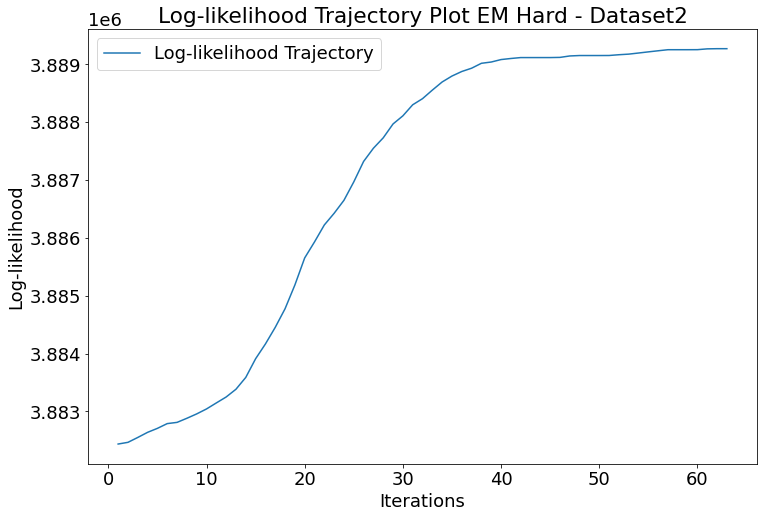

In [ ]:
# Dataset 2, K=4 hard step.
πs_d2, μs_d2, κs_d2, μs_history_d2, πs_history_d2, κs_history_d2, log_likelihood_d2, _, _ = pick_best_run(dataset2, 4, num_runs= 100, maxIters = 100)
print_results(πs_d2, μs_d2, κs_d2, log_likelihood_d2, max_iters=50, experiment_title = "EM Hard - Dataset2" )

**NMI Performance - EM vs KMeans**

In [ ]:
def get_NMI_performance_EM(data, em, labels, estep="s", K=3, num_runs=40, directed_assignment = False):
  '''Get the best, mean, standard deviation, and all the runs for the NMI performance of em and kmeans.'''
  best_nmi = 0
  all_nmi = []
  for i in range(num_runs):
    #  if em flag is true, run EM.
    if em:
       _, _, _, _, _, _, _, zs, _ = em_mix_vmfs(data, K = K, estep = estep, directed_assignment = directed_assignment)
    # Otherwise run spherical K means.
    else:
      _, zs, _ = sphericalKmeans(data, K=K)

    current_nmi = normalized_mutual_info_score(zs, labels)
    all_nmi.append(current_nmi)
    # if found a better nmi than the current best, assign it as the best.
    if current_nmi > best_nmi:
      best_nmi = current_nmi

  # Calculate mean and std of nmi.
  mean_nmi = np.mean(all_nmi)
  std_nmi = np.std(all_nmi)
  return best_nmi, mean_nmi, std_nmi, all_nmi

In [ ]:
# Get NMI performance EM undirected - soft.
best_nmi_em, mean_nmi_em, std_nmi_em, all_nmi_em = get_NMI_performance_EM(dataset2, True, dataset2_labels, K = 4, estep="s")

# Get NMI performance EM undirected - hard.
best_nmi_em_h, mean_nmi_em_h, std_nmi_em_h, all_nmi_em_h = get_NMI_performance_EM(dataset2, True, dataset2_labels,  K = 4, estep="h")

# Get NMI performance EM directed - soft.
best_nmi_em_directed, mean_nmi_em_directed, std_nmi_em_directed, all_nmi_em_directed = get_NMI_performance_EM(dataset2, True, dataset2_labels, K = 4, estep="s", directed_assignment = True)

# Get NMI performance EM directed - hard.
best_nmi_em_directed_h, mean_nmi_em_directed_h, std_nmi_em_directed_h, all_nmi_em_directed_h = get_NMI_performance_EM(dataset2, True, dataset2_labels, K = 4, estep="h", directed_assignment = True)

# Get NMI performance KMeans.
best_nmi_kmeans, mean_nmi_kmeans, std_nmi_kmeans, all_nmi_kmeans = get_NMI_performance_EM(dataset2, False, dataset2_labels, 4)

NMI Performance comparison - Dataset 2, K=4, 40 runs 

BEST NMI PERFORMANCE SCORE: 
 EM SOFT:0.6234345902679808, EM HARD: 0.01616872423487571
 EM DIRECTED SOFT: 0.8396243893142467 EM DIRECTED HARD: 0.7853641732306145
 KMEANS:0.4199587954939075

MEAN NMI PERFORMANCE SCORE: 
 EM SOFT:0.05913238488015813, EM HARD: 0.006454793101045689
 EM DIRECTED SOFT: 0.5270838363993656 EM DIRECTED HARD: 0.253847865943146
 KMEANS:0.23118397064409546

STANDARD DEVIATION: 
 EM SOFT:0.14104615155888298, EM HARD: 0.003057147276023532
 EM DIRECTED SOFT: 0.16686481700242195 EM DIRECTED HARD: 0.23607367740125185
 KMEANS:0.1341676786318907



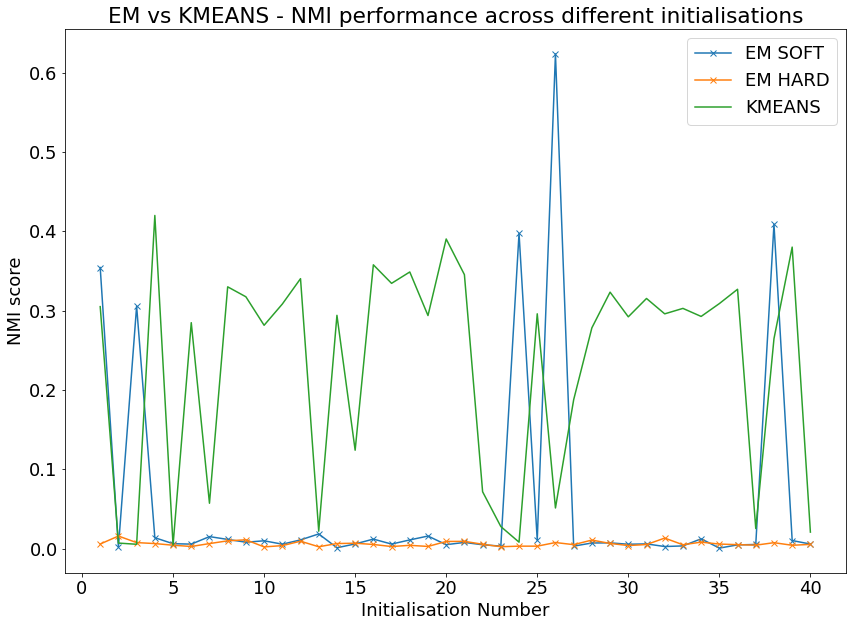

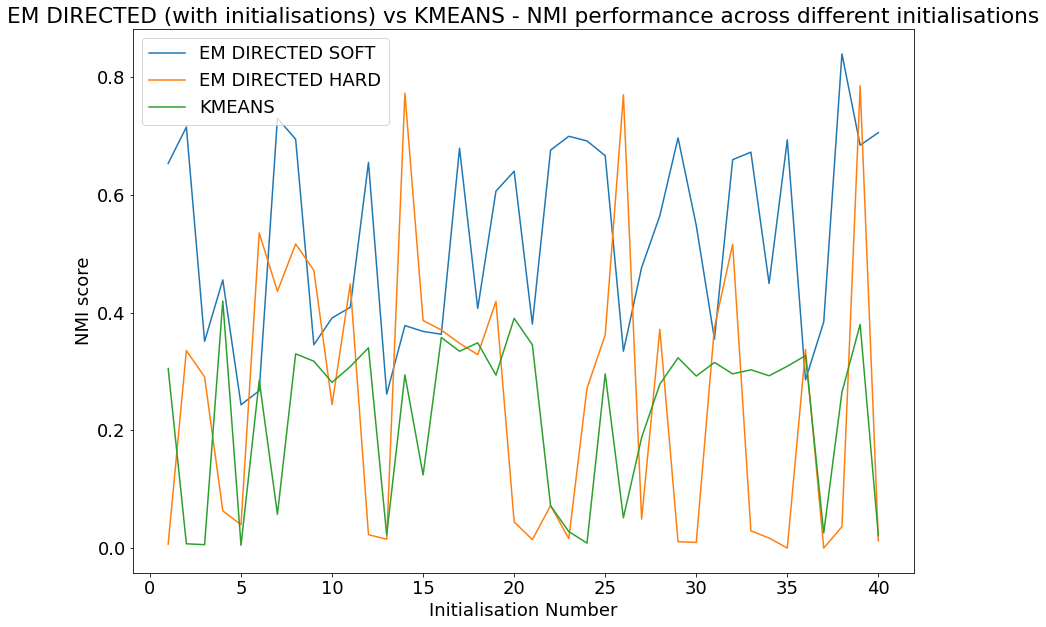

In [ ]:
print("NMI Performance comparison - Dataset 2, K=4, 40 runs \n")
print(f"BEST NMI PERFORMANCE SCORE: \n EM SOFT:{best_nmi_em}, EM HARD: {best_nmi_em_h}\n EM DIRECTED SOFT: {best_nmi_em_directed} EM DIRECTED HARD: {best_nmi_em_directed_h}\n KMEANS:{best_nmi_kmeans}\n")
print(f"MEAN NMI PERFORMANCE SCORE: \n EM SOFT:{mean_nmi_em}, EM HARD: {mean_nmi_em_h}\n EM DIRECTED SOFT: {mean_nmi_em_directed} EM DIRECTED HARD: {mean_nmi_em_directed_h}\n KMEANS:{mean_nmi_kmeans}\n")
print(f"STANDARD DEVIATION: \n EM SOFT:{std_nmi_em}, EM HARD: {std_nmi_em_h}\n EM DIRECTED SOFT: {std_nmi_em_directed} EM DIRECTED HARD: {std_nmi_em_directed_h}\n KMEANS:{std_nmi_kmeans}\n")

plt.figure(figsize=(14,10))
plt.title("EM vs KMEANS - NMI performance across different initialisations")
plt.plot(range(1,len(all_nmi_em)+1), all_nmi_em, label = "EM SOFT", marker="x")
plt.plot(range(1,len(all_nmi_em)+1), all_nmi_em_h, label = "EM HARD", marker="x")
plt.plot(range(1,len(all_nmi_em)+1), all_nmi_kmeans, label = "KMEANS")
plt.ylabel("NMI score")
plt.xlabel("Initialisation Number")
plt.legend()
plt.show()

plt.figure(figsize=(14,10))
plt.title("EM DIRECTED (with initialisations) vs KMEANS - NMI performance across different initialisations")
plt.plot(range(1,len(all_nmi_em)+1), all_nmi_em_directed, label = "EM DIRECTED SOFT")
plt.plot(range(1,len(all_nmi_em)+1), all_nmi_em_directed_h, label = "EM DIRECTED HARD")
plt.plot(range(1,len(all_nmi_em)+1), all_nmi_kmeans, label = "KMEANS")
plt.ylabel("NMI score")
plt.xlabel("Initialisation Number")
plt.legend()
plt.show()

**Observations**
1. The performance of the algorithm is greatly dependent on the initialisation step. If a bad random guess occurs then the algorithms will perform significantly better, especially on such high-dimensional data. The directed EM algorithm seems to work better because its less likely to make a very bad initial guess.
2. The **directed EM** has the highest best NMI score and average (for both soft and hard). The soft version of normal EM found a better solution than KMeans but had a lower average NMI score. 
3. The fact that EM performs better when a given range estimate is given means that it might be a very good algorithm if you have some understanding/knowledge about the data.
4.   When the normal EM (not directed) makes a bad initialisation it performs worse than KMeans. This is evident when comparing the NMI means of the algorithms.
5. The EM algorithm with the hard step does not perform very well when an informed range is not given (direction). It also appears that the EM soft step outperforms the hard step for NMI score in almost all the runs for our specific example.
6.   The normal EM algorithm has greater standard deviation in its performance -> further proving that its performance greatly varies depending on initialisation.
7. The results suggest that when no range is given (`directed_assignment = False`), the EM algorithm might struggle to make a good initial assignment on high dimensional data.




## Task 3: Advanced Tasks (incremental EM)

For datasets with enormous amount of observations, it is not practical to run a full E-step on all data points. An alternative, called incremental-EM, is to visit each data one by one in E step (called partial E-step) and immediately followed by a re-estimation M step. The algorithm has been found to converge faster than the batch EM [1]. The algorithm follows the following steps:

* Initialisation (you need to populate the required sufficient statistics $s_k$ for $k = 1,\ldots, K$)
* Repeat until converge
  * for each $x_i$ in data (any visiting order works but random shuffle works the best)
    * partial E-step: $w_{ik} = P(z_i=k|x_i, \{\mu_k, \kappa_k,\pi_k\}_{k=1}^K)$ for $k=1,\ldots, K$
    * update sufficient statistics $s_k$ according to $\{w_{ik}\}$
    * M-step: re-estimate parameters based on $s_k$
    
Hint: the key step is to think what sufficient statistics are required for the estimation step and come up with an efficient update procedure for $s_k$. Once you have identified the correct sufficient statistics, you now only need to come up with a sensible way to update the sufficient statistics incrementally.

#### Task 3.1 Incremental EM algorithm

Based on the provided information and hint, implement an incremental EM algorithm that can fit a finite mixture of von Mises-Fisher. 

In [ ]:
def increm_em_mix_vmfs(data, K=3, tol= 1e-4, maxIters= 100):
    '''The incremental EM algorithm, using partial E-Step.'''
    n, d = data.shape 
    z_init = rng.integers(K, size=n)
    ws = np.eye(K)[z_init]

    # Initialise sufficient statistics using m_step.
    πs, μs, κs = m_step(data, ws)
    
    log_likelihoods = []

    converged = False
    i = 0
    
    while(not converged and i < maxIters):
      # shuffle samples.
      samples = np.arange(n)
      rng.shuffle(samples)
      log_likelihood_for_sample = []
      # Iterate through the samples.
      for x in samples:
        # Do estimation for current sample. Change only row by row.
        ws[x], log_likelihood = e_step(np.expand_dims(data[x], axis=0), πs, μs, κs) 
        log_likelihood_for_sample.append(log_likelihood)
        # Immediately update the parameters.
        πs, μs, κs = m_step(data, ws)

      # Check if the algorithm converged - done outside of inner loop to be able
      # to effectively compare with other algorithms.
      log_likelihoods.append(np.sum(log_likelihood_for_sample))
      if i > 0 and abs(log_likelihoods[i] - log_likelihoods[i-1]) <= tol:
        converged = True
        break;

      i += 1 # increment if it didnt converge yet.

    # Get labels.
    zs = np.argmax(ws, axis=1)

    return log_likelihoods, πs, μs, κs, zs

#### Task 3.2 Comparison: incremental EM vs batch EM

Compare the incremental EM with the batch EM algorithm. You may want to reuse the given datasets or simulate more datasets if you want. The objective is to show the strength (or weakness) of the incremental algorithm over its batch variant empirically on convergence speed and clustering accuracy. 

**Convergence Speed**

All the tests performed are using the same dataset and number of Ks. Furthermore, only the "undirected" (without initial informed assignments - `directed_assignment = False`) version of the Batch algorithm is used to ensure fair comparison.

In [ ]:
def compare_convergence_speed(data, num_runs = 20, K=3, maxIters = 100):
  '''Compare convergence speed and NMI score between Batch EM and Incremental EM.'''
  convergence_times_em = []
  convergence_times_em_incremental = []

  for i in range(num_runs):
    # Get convergence time for batch EM.
    _, _, _, _, _, _, log_lik, zs, _ = em_mix_vmfs(data, K=K, maxIters=maxIters)
    likelihood_trimmed = log_lik[log_lik != 0] # trim all the zeros at the end.
    convergence_times_em.append(len(likelihood_trimmed))

    # Get convergence time for incremental EM.
    log_lik_incremental, _, _ , _, zs_incremental = increm_em_mix_vmfs(data, K=K)
    convergence_times_em_incremental.append(len(log_lik_incremental))

  mean_em = np.mean(convergence_times_em)
  mean_em_incremental = np.mean(convergence_times_em_incremental)

  std_em = np.std(convergence_times_em)
  std_em_incremental = np.std(convergence_times_em_incremental)

  return mean_em, mean_em_incremental, std_em, std_em_incremental

In [ ]:
def plot_convergence_speed(mean_em, mean_em_incremental, title, num_runs = 20):
  # Plot the average number of iterations for the two algorithms to converge.
  fig = plt.figure(figsize = (10,8))
  ax = fig.add_axes([0,0,1,1])
  ax.bar(1, mean_em, color='r')
  ax.bar(2, mean_em_incremental,  color='b')
  ax.set_ylabel('Iterations')
  ax.set_title(f'{title} - Average Number of Iterations to Converge - {num_runs} runs')
  ax.legend(labels=['Batch EM', 'Incremental EM'])
  plt.xticks([])
  plt.show()

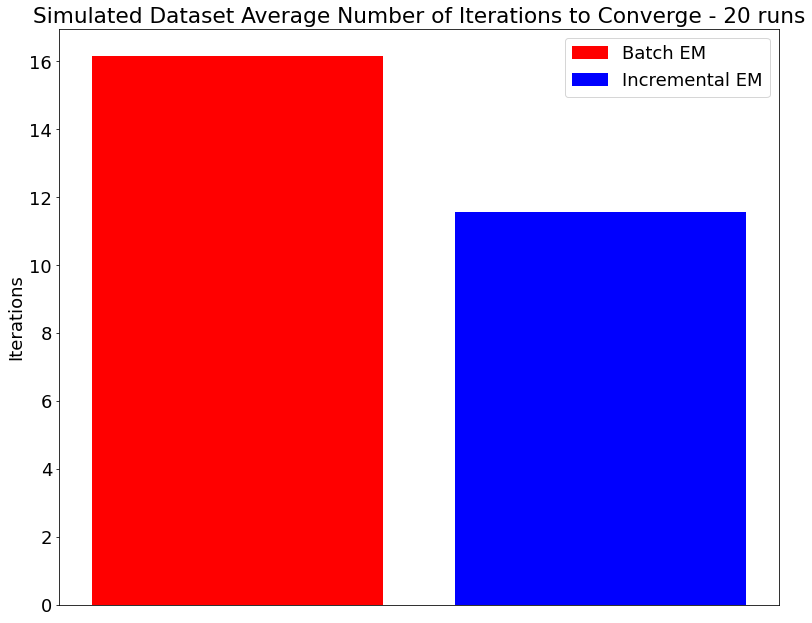

In [ ]:
mean_em_sim, mean_em_incremental_sim, std_em_sim, std_em_incremental_sim = compare_convergence_speed(simData)
plot_convergence_speed(mean_em_sim, mean_em_incremental_sim, "Simulated Dataset", num_runs=20)

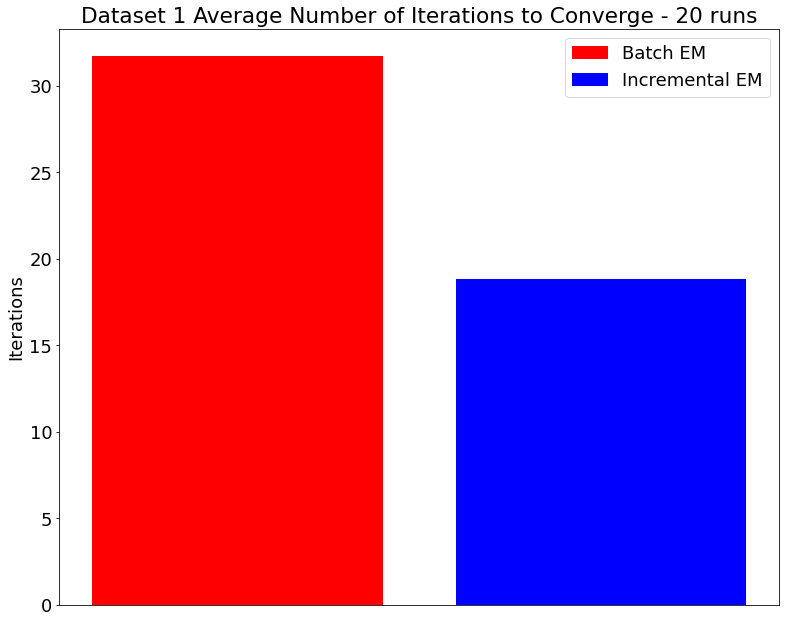

In [ ]:
mean_em_d1, mean_em_incremental_d1, std_em_d1, std_em_incremental_d1  = compare_convergence_speed(dataset1)
plot_convergence_speed(mean_em_d1, mean_em_incremental_d1, "Dataset 1", num_runs=20)

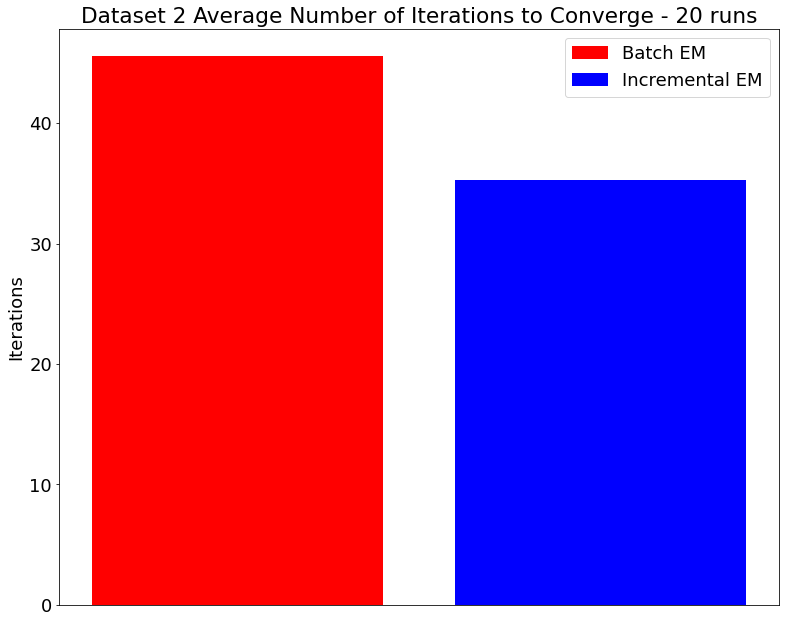

In [ ]:
mean_em_d2, mean_em_incremental_d2, std_em_d2, std_em_incremental_d2  = compare_convergence_speed(dataset2)
plot_convergence_speed(mean_em_d2, mean_em_incremental_d2, "Dataset 2", num_runs=20)

As evident the Incremental EM algorithm converges faster than the Batch EM algorithm in all 3 (`simData`, `dataset1`, `dataset2`) datasets tried. 

**Clustering Accuracy - Dataset 2**

In [ ]:
def get_NMI_performance_EM_incremental(data,labels, K=3, num_runs=40):
  '''Get the best, mean, standard deviation, and all the runs for the NMI performance of the incremental EM.'''
  best_nmi = 0
  all_nmi = []
  for i in range(num_runs):
    # Get zs for incremental EM on passed in dataset.
    _, _, _ , _, zs = increm_em_mix_vmfs(data, K=K)
    current_nmi = normalized_mutual_info_score(zs, labels)
    all_nmi.append(current_nmi)
    # if found a better nmi than the current best, assign it as the best.
    if current_nmi > best_nmi:
      best_nmi = current_nmi

  # Calculate mean and std of nmi.
  mean_nmi = np.mean(all_nmi)
  std_nmi = np.std(all_nmi)
  return best_nmi, mean_nmi, std_nmi, all_nmi

In [ ]:
# Get the NMI performance for the EM incremental algorithm for 40 runs.
best_nmi_em_incremental, mean_nmi_em_incremental, std_nmi_em_incremental, all_nmi_em_incremental = get_NMI_performance_EM_incremental(dataset2, dataset2_labels, K = 4)

NMI Performance comparison - Dataset 2, K=4, 40 runs 

BEST NMI PERFORMANCE SCORE: 
 EM SOFT:0.6234345902679808
 EM INCREMENTAL: 0.3775494550647624

MEAN NMI PERFORMANCE SCORE: 
 EM SOFT:0.05913238488015813
 EM INCREMENTAL: 0.05208678028530054

STANDARD DEVIATION: 
 EM SOFT:0.14104615155888298
 EM INCREMENTAL: 0.11711972169644097



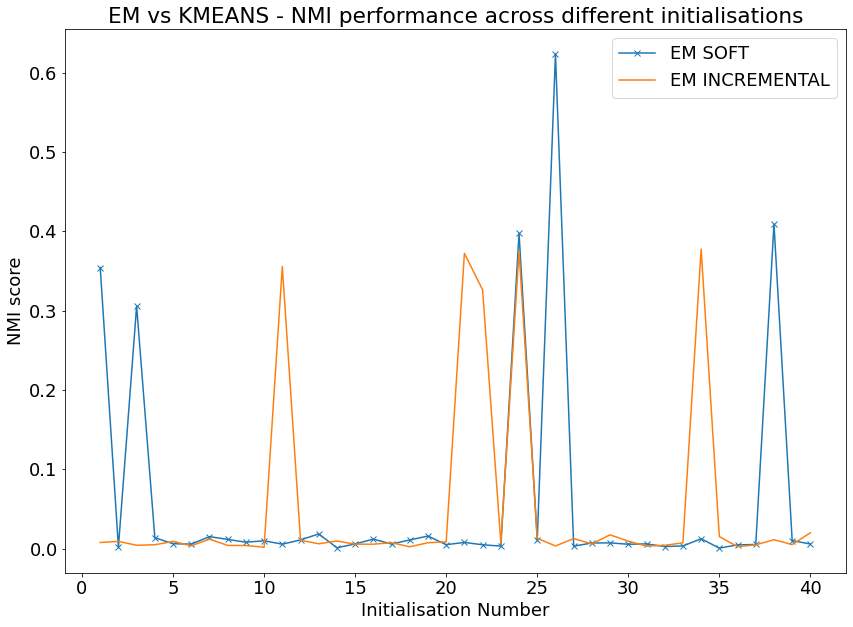

In [ ]:
print("NMI Performance comparison - Dataset 2, K=4, 40 runs \n")
print(f"BEST NMI PERFORMANCE SCORE: \n EM SOFT:{best_nmi_em}\n EM INCREMENTAL: {best_nmi_em_incremental}\n")
print(f"MEAN NMI PERFORMANCE SCORE: \n EM SOFT:{mean_nmi_em}\n EM INCREMENTAL: {mean_nmi_em_incremental}\n")
print(f"STANDARD DEVIATION: \n EM SOFT:{std_nmi_em}\n EM INCREMENTAL: {std_nmi_em_incremental}\n")

plt.figure(figsize=(14,10))
plt.title("EM vs KMEANS - NMI performance across different initialisations")
plt.plot(range(1,len(all_nmi_em)+1), all_nmi_em, label = "EM SOFT", marker="x")
plt.plot(range(1,len(all_nmi_em)+1), all_nmi_em_incremental, label = "EM INCREMENTAL")
plt.ylabel("NMI score")
plt.xlabel("Initialisation Number")
plt.legend()
plt.show()

The two algorithms have very similar accuracy performance.
*   Both algorithms suffer from bad initialisation.
*   The Batch EM was able to produce the highest NMI score (for one of its runs). However their overall performance is very similar - as they have almost identical NMI mean, and close standard deviation values.
* From my results it was therefore found that the incremental algorithm indeed improves convergence speed but does not seem to have a significant effect on the clustering accuracy (at least for this dataset).

## Hints

Here are some general hints that might be helpful:
* The implementations of the algorithms for vMFs should be very similar to their Gaussian mixture counterparts. Check Week 7's Lab (Python implementation) or Lecture 11 and 12's lecture Pluto notebook (algorithms implemented in Julia) if you have no clue how to start.
* The following methods or packages from numpy might be useful: `linalg.norm(), rng.choice(), np.sum(), np.mean(), np.min/max/argmin/argmax()`; check numpy documentation for more details.
* When dealing with probabilities, it is almost always more numerically stable and efficient to do calculations in log-space. 
* You should also think about boundary or extreme scenarios which might lead to unexpected outputs. Make sure your implementation is reasonably robust. In particular, the normalising constant of von Mises-Fisher, $c_d(\kappa)$, is very sensitive to very large values of $\kappa$. A sensible remedy to cap its value to some finite range, $\kappa_{\text{min}} = 10^{-6}, \kappa_{\text{max}} = 10^4$. However, you need to think in which situations to apply the cap. 
* When it comes to comparing performances of algorithms objectively, you should never reach a conclusion by only running an experiment once. A common practice is to repeat a few times (say 10 times) and report the mean (and standard error).
* The background information provided here together with what is covered in the lectures should be completely self-contained for you to finish all tasks. In other words, you do not need to derive any further mathematical equations to finish this practical. If you feel otherwise, the chance is you are on a wrong track or over-engineering your implementation. 

## References

[1] Neal, R.M. and Hinton, G.E., 1998. A view of the EM algorithm that justifies incremental, sparse, and other variants. In Learning in graphical models (pp. 355-368). Springer, Dordrecht.